# GRN polioudakis 19 - based on scFates milestones

In [1]:
pwd

'/home/jovyan/jm_jlab/data_CBL/indNeuro_tmp/1.GRN'

In [2]:
!cd /home/jovyan/jm_jlab/

In [3]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [4]:
import celloracle as co
co.__version__

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


'0.10.14'

In [5]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = (15,7)
plt.rcParams["savefig.dpi"] = 600

In [6]:
!pwd

/home/jovyan/jm_jlab/data_CBL/indNeuro_tmp/1.GRN


In [7]:
save_folder = "/home/jovyan/jm_jlab/celloracle_data/figures_tutorial"
os.makedirs(save_folder, exist_ok=True)

In [8]:
from pathlib import Path

In [9]:
sc._settings.ScanpyConfig.cachedir = Path('/home/jovyan/jm_jlab/celloracle_data/cache')

In [10]:
!mkdir /home/jovyan/jm_jlab/data_indNeuro/consensus_atlas_ATACregions_hg38/GRN_polioudakis19

mkdir: cannot create directory ‘/home/jovyan/jm_jlab/data_indNeuro/consensus_atlas_ATACregions_hg38/GRN_polioudakis19’: File exists


In [11]:
save_filtered_links = '/home/jovyan/jm_jlab/data_indNeuro/consensus_atlas_ATACregions_hg38/GRN_polioudakis19/'

## **RNA**

In [12]:
adata = sc.read_h5ad("/home/jovyan/jm_jlab/data_indNeuro/intermediate_files/pol19_counts.h5ad")

milestones = pd.read_csv("/home/jovyan/jm_jlab/data_indNeuro/scFates_output/polioudakis19_scFates_clustering.tsv", sep='\t', index_col=0)

adata.obs = pd.concat([adata.obs, milestones], axis=1)

In [13]:
adata.obs['Gestation_week'].value_counts()

18    1915
17    1752
Name: Gestation_week, dtype: int64

In [14]:
cellembeddings = pd.read_csv("/home/jovyan/jm_jlab/data_indNeuro/intermediate_files/integrated_polioudakis19_cellembeddings.tsv", sep='\t')

cellembeddings.iloc[:,0] = cellembeddings.iloc[:,0]*-1 #for consistent better geometry

cellembeddings.iloc[:,1] = cellembeddings.iloc[:,1]*-1 #for consistent better geometry

cellembeddings = cellembeddings[cellembeddings.index.str.contains("pol19")]

cellembeddings.index = pd.DataFrame(cellembeddings.index)[0].str.split("pol19_", expand=True)[1]

adata = adata[adata.obs.index.isin(cellembeddings.index),:].copy()

cellembeddings = cellembeddings[cellembeddings.index.isin(adata.obs.index)].copy()

cellembeddings = cellembeddings.reindex(adata.obs.index)

In [15]:
adata.obsm['X_pca'] = cellembeddings.to_numpy() #sharing embeddings

In [16]:
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor='seurat_v3') #let's retain more genes before further filtering

adata=adata[:,adata.var.highly_variable]

sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')

# keep raw cont data before log transformation
adata.raw = adata.copy()
adata.layers["raw_count"] = adata.raw.X.copy()

# Log transformation
sc.pp.log1p(adata)

In [17]:
print("Number of cells: %d" %adata.shape[0])

Number of cells: 3667


In [18]:
adata.obs['Gestation_week'].value_counts()

18    1915
17    1752
Name: Gestation_week, dtype: int64

**Pseudotime**

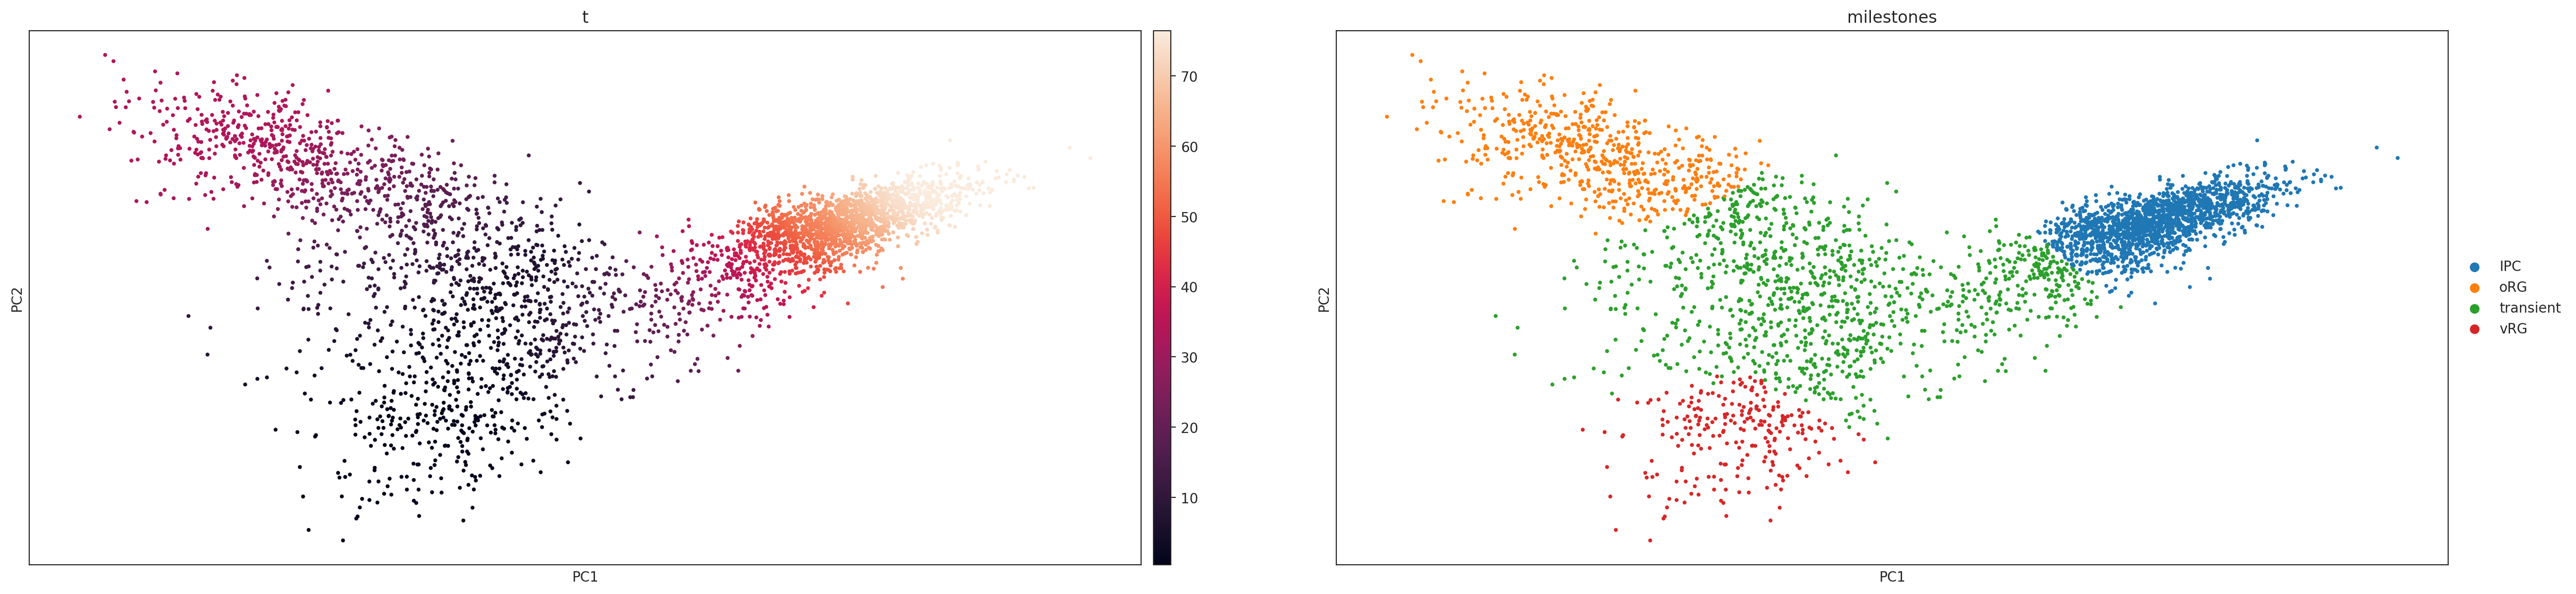

In [19]:
sc.pl.pca(adata, color=['t', 'milestones'])

**Final object**

In [20]:
adata

AnnData object with n_obs × n_vars = 3667 × 4000
    obs: 'orig.ident', 'Cluster', 'Subcluster', 'Donor', 'Layer', 'Gestation_week', 'Library', 'percent.mt', 'percent.zeros', 'nCount_RNA', 'nFeature_RNA', 'milestones', 'segmentation', 't', 'n_counts_all'
    var: 'features', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'milestones_colors'
    obsm: 'X_pca'
    layers: 'raw_count'

## **PEAKS**

In [21]:
import os, sys, shutil, importlib, glob
from tqdm.notebook import tqdm

In [22]:
from celloracle import motif_analysis as ma
from celloracle.utility import save_as_pickled_object

In [23]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = (15,7)
plt.rcParams["savefig.dpi"] = 600

In [24]:
df = pd.read_parquet("/home/jovyan/jm_jlab/data_indNeuro/consensus_atlas_ATACregions_hg38/base_GRN_dataframe_HOCOMOCOv11.parquet")

In [25]:
df.head(2)

peak_id gene_short_name  AHR  AIRE  ALX1   AR  ARID5B  \
0  chr10_100006240_100006741           ABCC2  0.0   0.0   0.0  0.0     0.0   
1  chr10_100006240_100006741           DNMBP  0.0   0.0   0.0  0.0     0.0   

   ARNT  ARNTL  ASCL1  ...  ZNF680  ZNF708  ZNF76  ZNF768  ZNF770  ZNF8  \
0   0.0    0.0    0.0  ...     0.0     0.0    0.0     0.0     0.0   0.0   
1   0.0    0.0    0.0  ...     0.0     0.0    0.0     0.0     0.0   0.0   

   ZNF816  ZNF85  ZSCAN22  ZSCAN31  
0     0.0    0.0      0.0      0.0  
1     0.0    0.0      0.0      0.0  

[2 rows x 401 columns]

## 

## Init CellOracle

In [26]:
# Instantiate Oracle object
oracle = co.Oracle()

In [27]:
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.10.14
    n_cells: NA
    n_genes: NA
    cluster_name: None
    dimensional_reduction_name: None
    k_for_knn_imputation: NA
Status
    Gene expression matrix: Not imported
    BaseGRN: Not imported
    PCA calculation: Not finished
    Knn imputation: Not finished
    GRN calculation for simulation: Not finished

In [28]:
# Show data name in anndata
print("metadata columns :", list(adata.obs.columns))
print("dimensional reduction: ", list(adata.obsm.keys()))


metadata columns : ['orig.ident', 'Cluster', 'Subcluster', 'Donor', 'Layer', 'Gestation_week', 'Library', 'percent.mt', 'percent.zeros', 'nCount_RNA', 'nFeature_RNA', 'milestones', 'segmentation', 't', 'n_counts_all']
dimensional reduction:  ['X_pca']


In [29]:
adata = adata.copy()

# In this notebook, we use the unscaled mRNA count for the input of Oracle object.
adata.X = adata.layers["raw_count"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="milestones",
                                   embedding_name="X_pca") #It performs log-transform

**HOMOCOCO CELLORACLE OBJECT:**

In [30]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=df)

# Alternatively, if you saved the informmation as a dictionary, you can use the code below.
# oracle.import_TF_data(TFdict=TFinfo_dictionary)

In [31]:
oracle #very few n_regulatory_in_both_TFdict_and_scRNA-seq for JASPAR and HOMER.

Oracle object

Meta data
    celloracle version used for instantiation: 0.10.14
    n_cells: 3667
    n_genes: 4000
    cluster_name: milestones
    dimensional_reduction_name: X_pca
    n_target_genes_in_TFdict: 18193 genes
    n_regulatory_in_TFdict: 399 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 96 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 3389 genes
    k_for_knn_imputation: NA
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Not finished
    Knn imputation: Not finished
    GRN calculation for simulation: Not finished

29


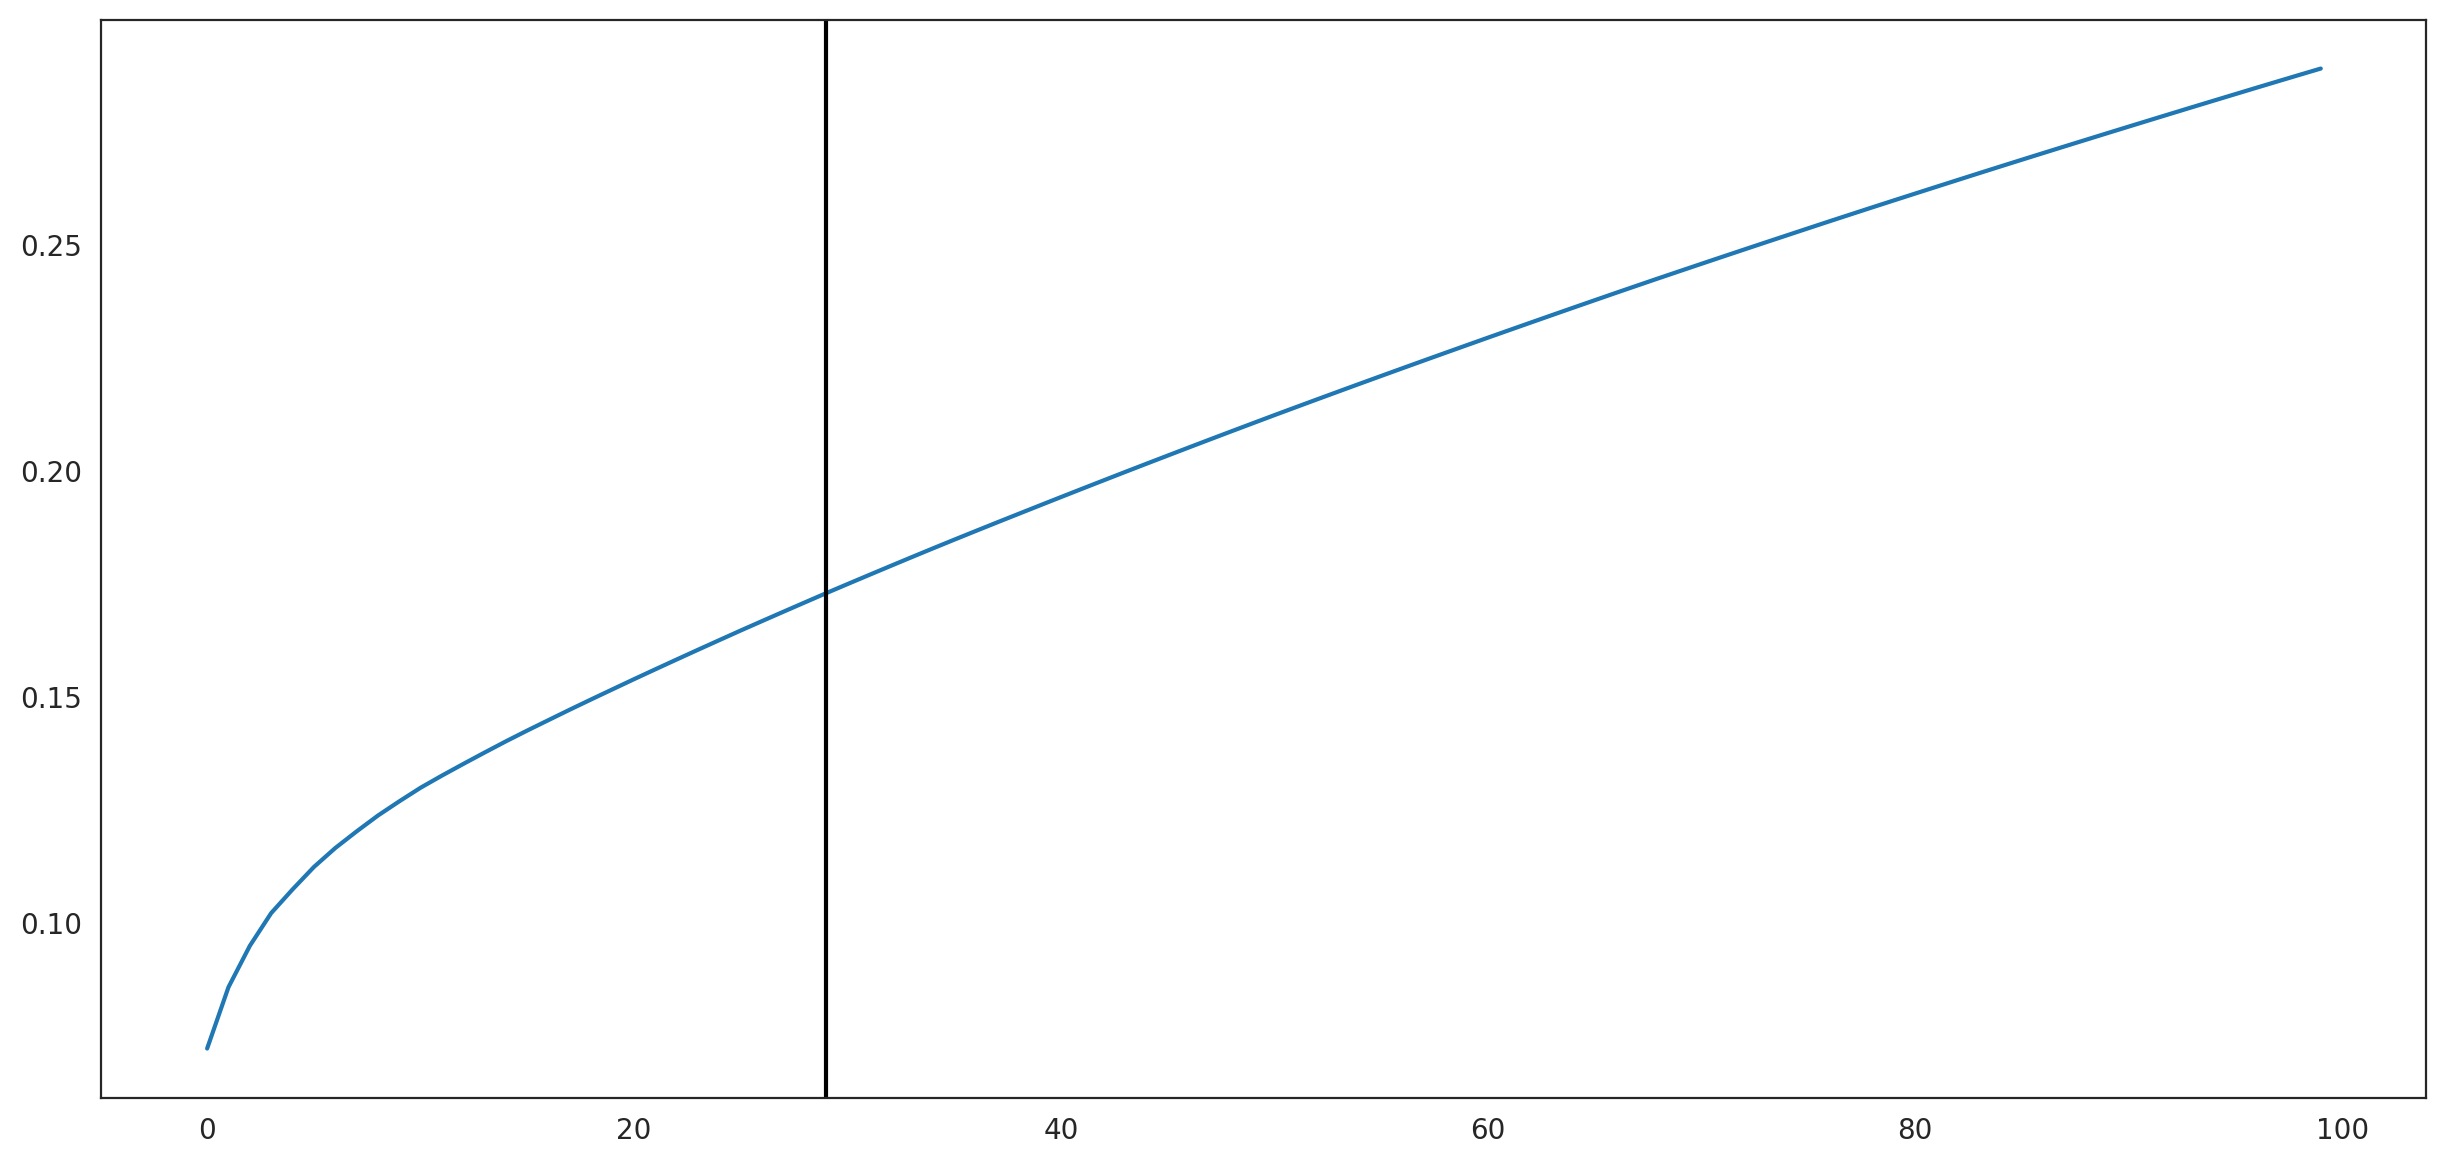

In [32]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
print(n_comps)
n_comps = min(n_comps, 50)

In [33]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :3667


In [34]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :91


In [35]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=14)

In [36]:
%%time
# Calculate GRN for each population clustering unit.

links = oracle.get_links(cluster_name_for_GRN_unit='milestones', 
                         alpha=25,
                         bagging_number=20, 
                         verbose_level=10, 
                         test_mode=False, 
                         model_method="bagging_ridge", 
                         ignore_warning=False, n_jobs=-1)

  0%|          | 0/4 [00:00<?, ?it/s]

Inferring GRN for IPC...


  0%|          | 0/3389 [00:00<?, ?it/s]

Inferring GRN for oRG...


  0%|          | 0/3389 [00:00<?, ?it/s]

Inferring GRN for transient...


  0%|          | 0/3389 [00:00<?, ?it/s]

Inferring GRN for vRG...


  0%|          | 0/3389 [00:00<?, ?it/s]

CPU times: user 14min 30s, sys: 1min 24s, total: 15min 55s
Wall time: 15min 56s


In [37]:
%%time
# Calculate GRN for each population clustering unit.

links_bayesian_ridge = oracle.get_links(cluster_name_for_GRN_unit='milestones', 
                         alpha=25, 
                         bagging_number=20, 
                         verbose_level=10, 
                         test_mode=False, 
                         model_method="bayesian_ridge", 
                         ignore_warning=False, n_jobs=-1)

  0%|          | 0/4 [00:00<?, ?it/s]

Inferring GRN for IPC...


  0%|          | 0/3389 [00:00<?, ?it/s]

/root/miniconda/envs/celloracle_env/lib/python3.8/site-packages/celloracle/network/net_core.py:651: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


Inferring GRN for oRG...


  0%|          | 0/3389 [00:00<?, ?it/s]

Inferring GRN for transient...


  0%|          | 0/3389 [00:00<?, ?it/s]

Inferring GRN for vRG...


  0%|          | 0/3389 [00:00<?, ?it/s]

CPU times: user 7min 3s, sys: 24.9 s, total: 7min 28s
Wall time: 52.8 s


In [38]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

In [39]:
links_bayesian_ridge.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

In [40]:
for i in links.filtered_links.keys():

    links.filtered_links[i].to_csv(save_filtered_links+"GRN_for_"+i+"_baggingridge_pol19.csv", index=False)

In [41]:
for i in links.filtered_links.keys():

    links_bayesian_ridge.filtered_links[i].to_csv(save_filtered_links+"alt_GRN_for_"+i+"_bayesianridge_pol19.csv", index=False)

In [42]:
plt.rcParams["figure.figsize"] = [6, 4.5]

IPC


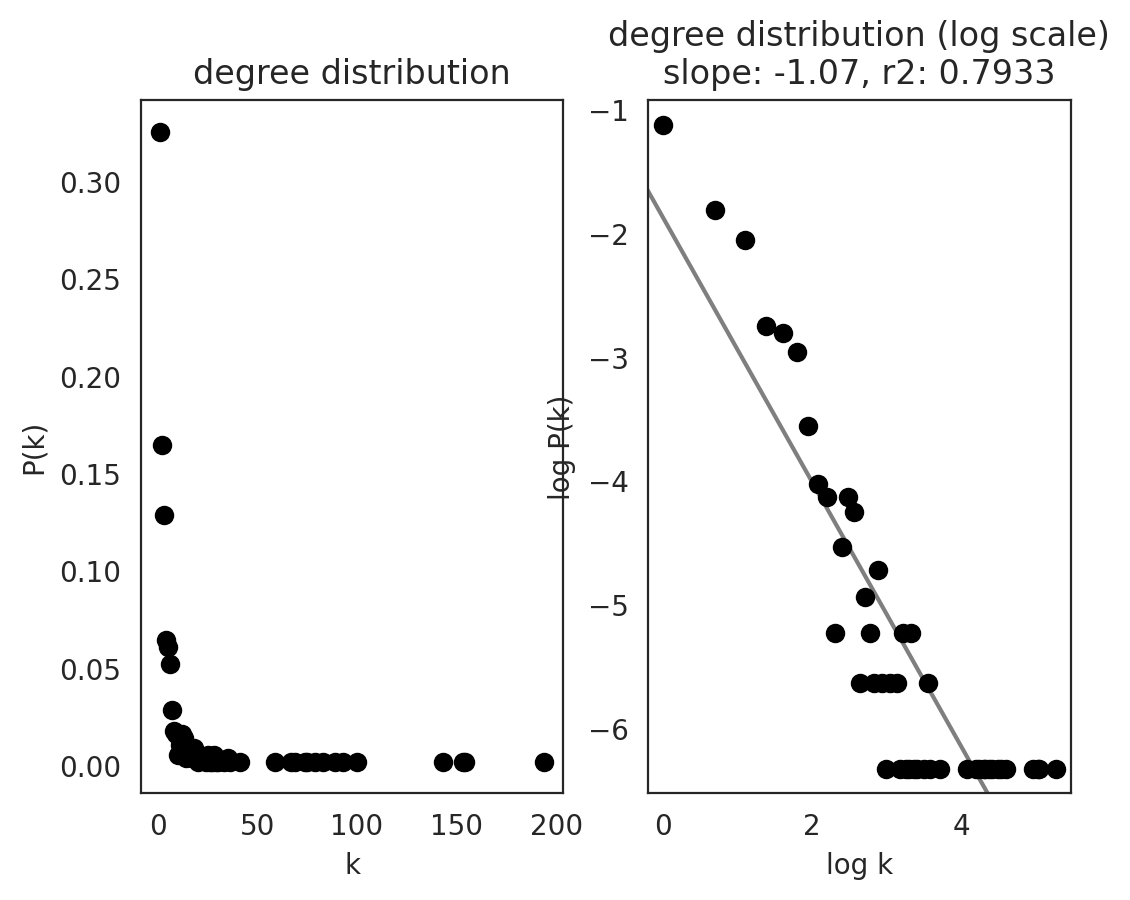

oRG


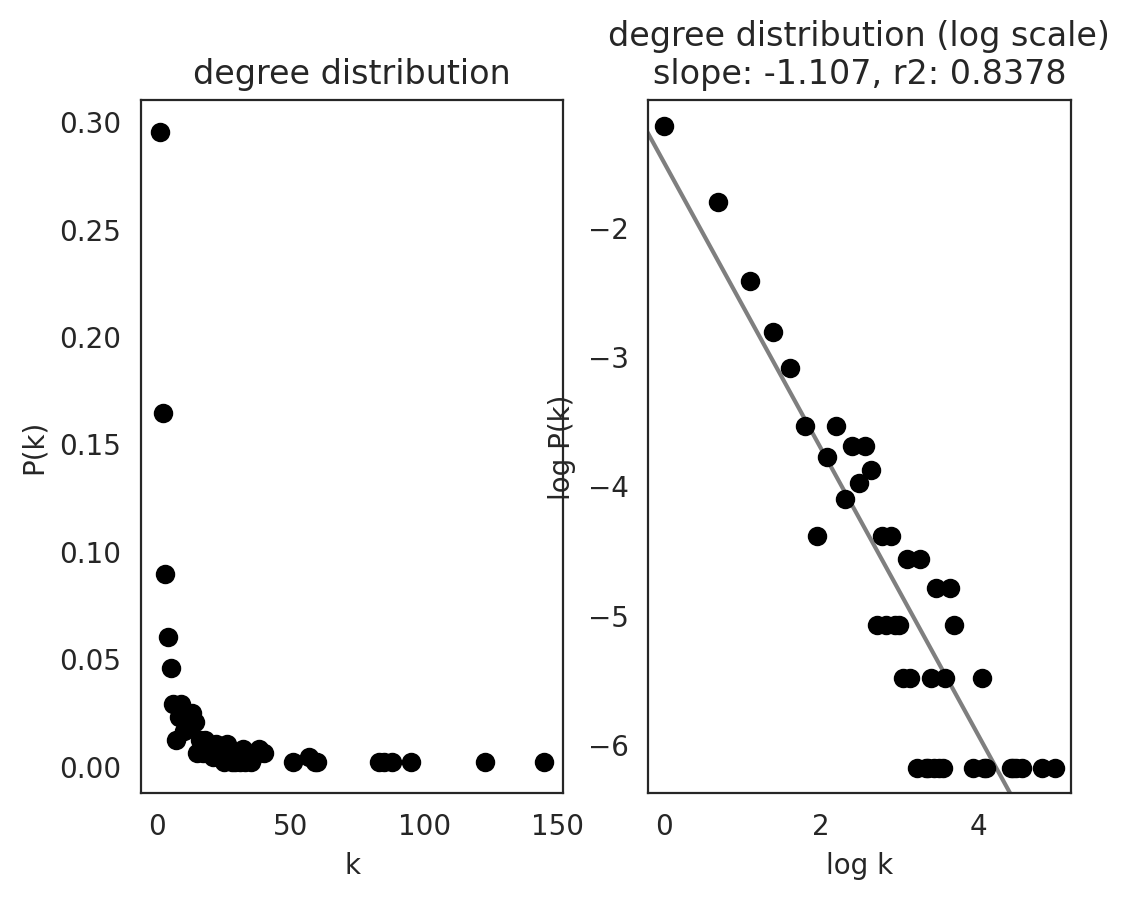

transient


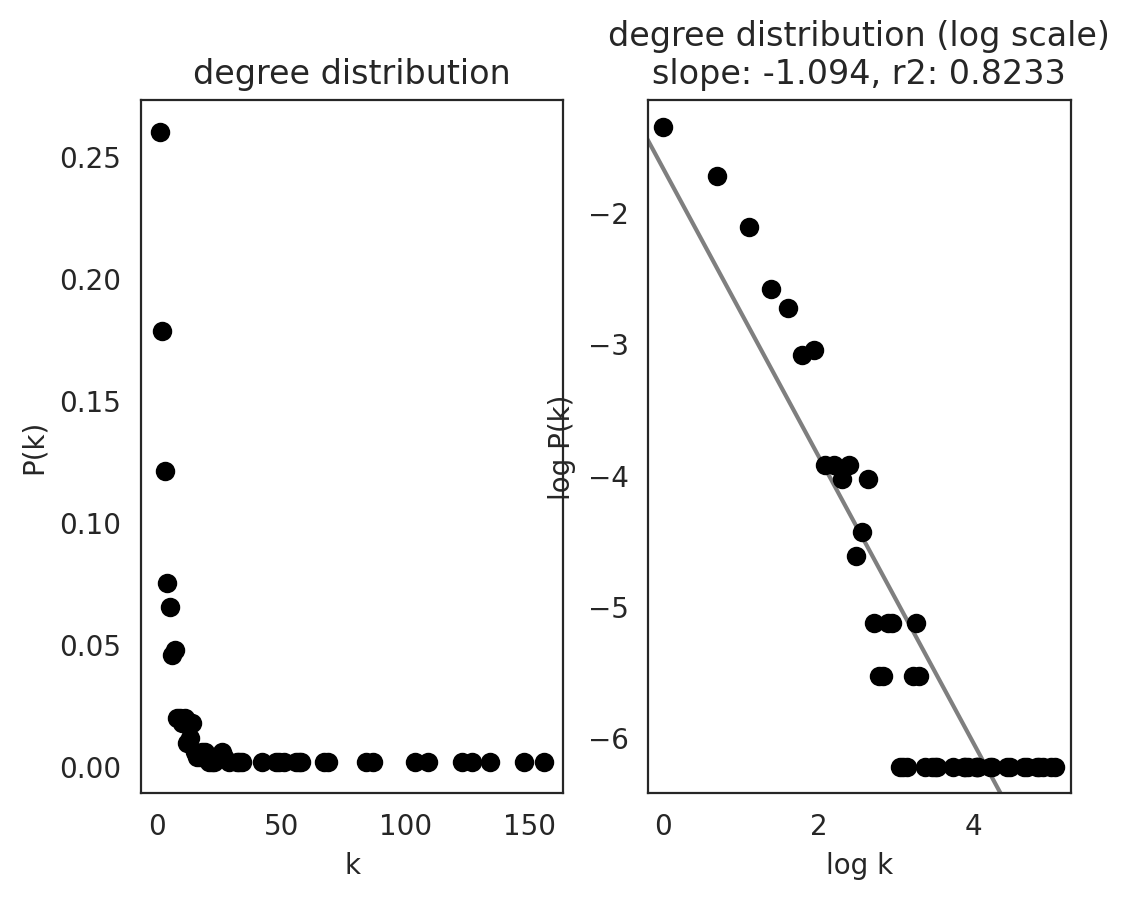

vRG


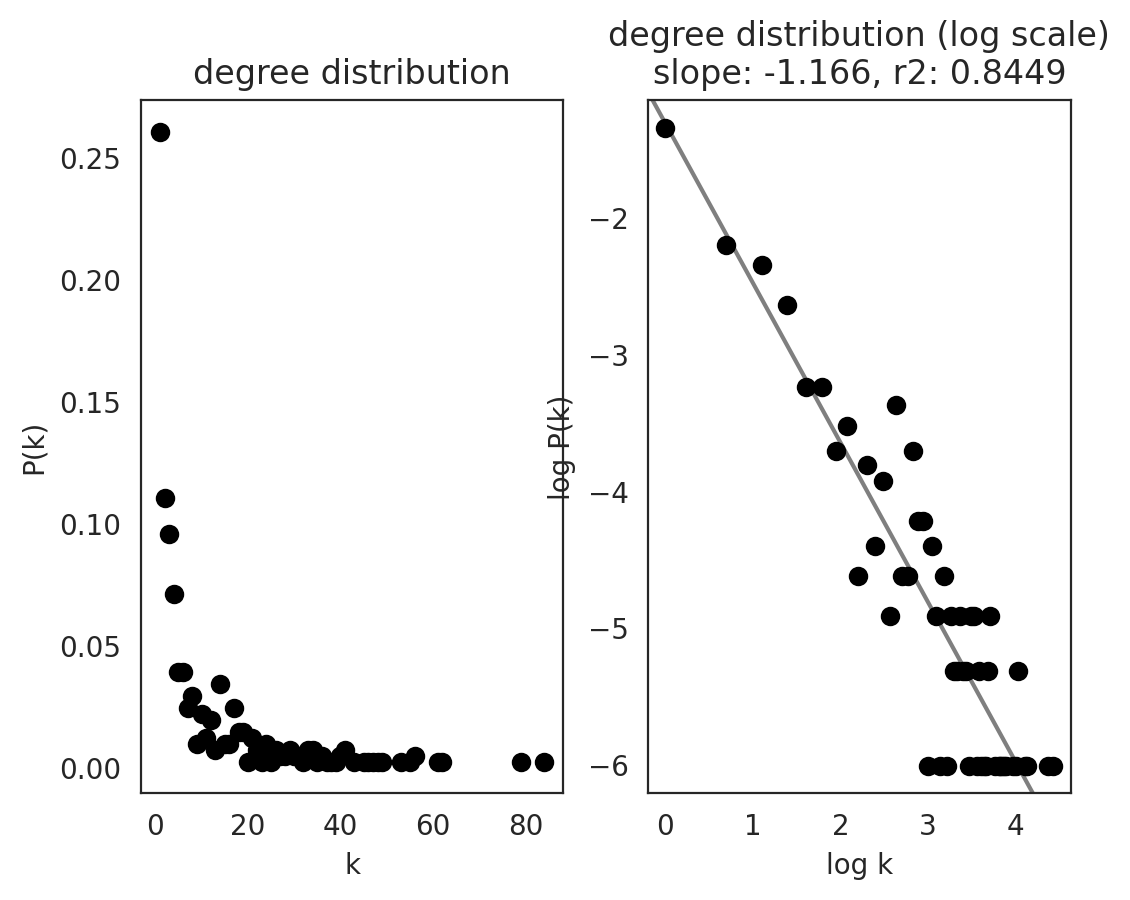

In [43]:
links.plot_degree_distributions(plot_model=True)#save=f"{save_folder}/degree_distribution/",)

IPC


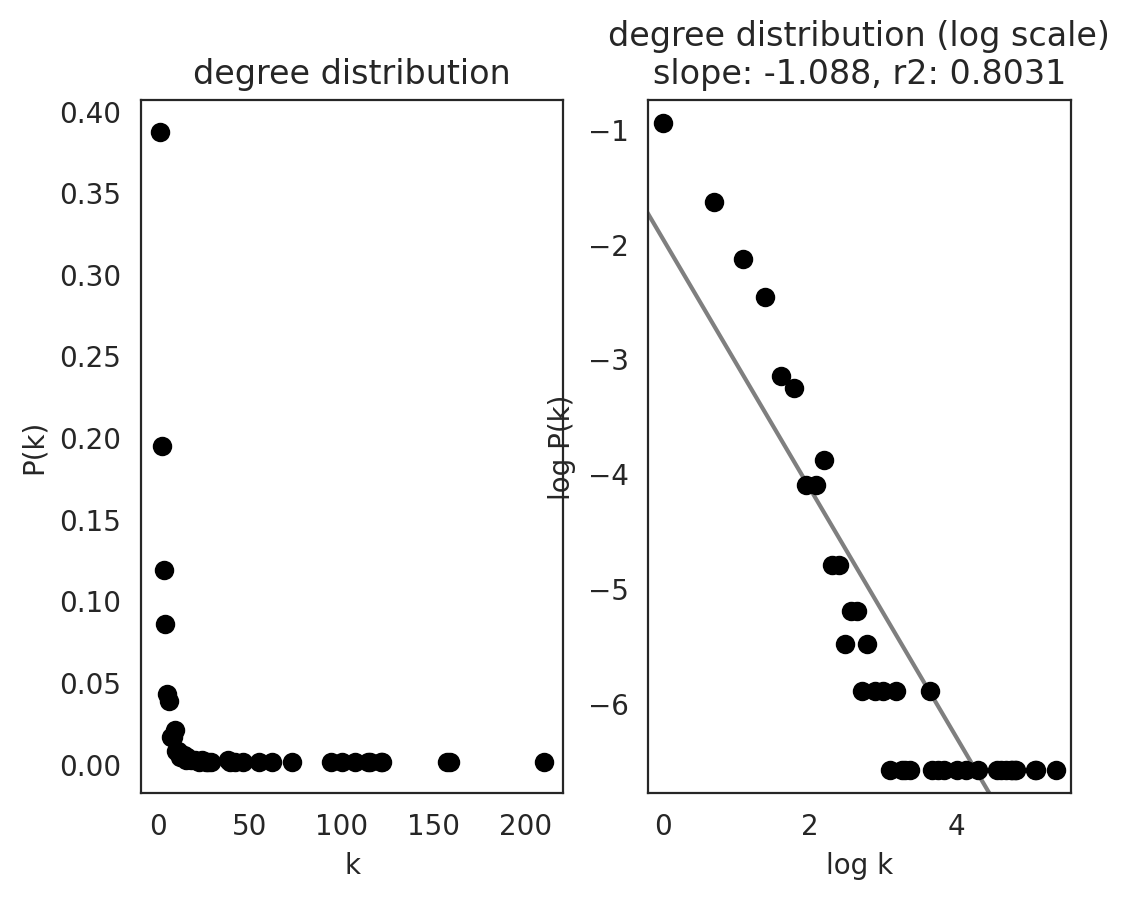

oRG


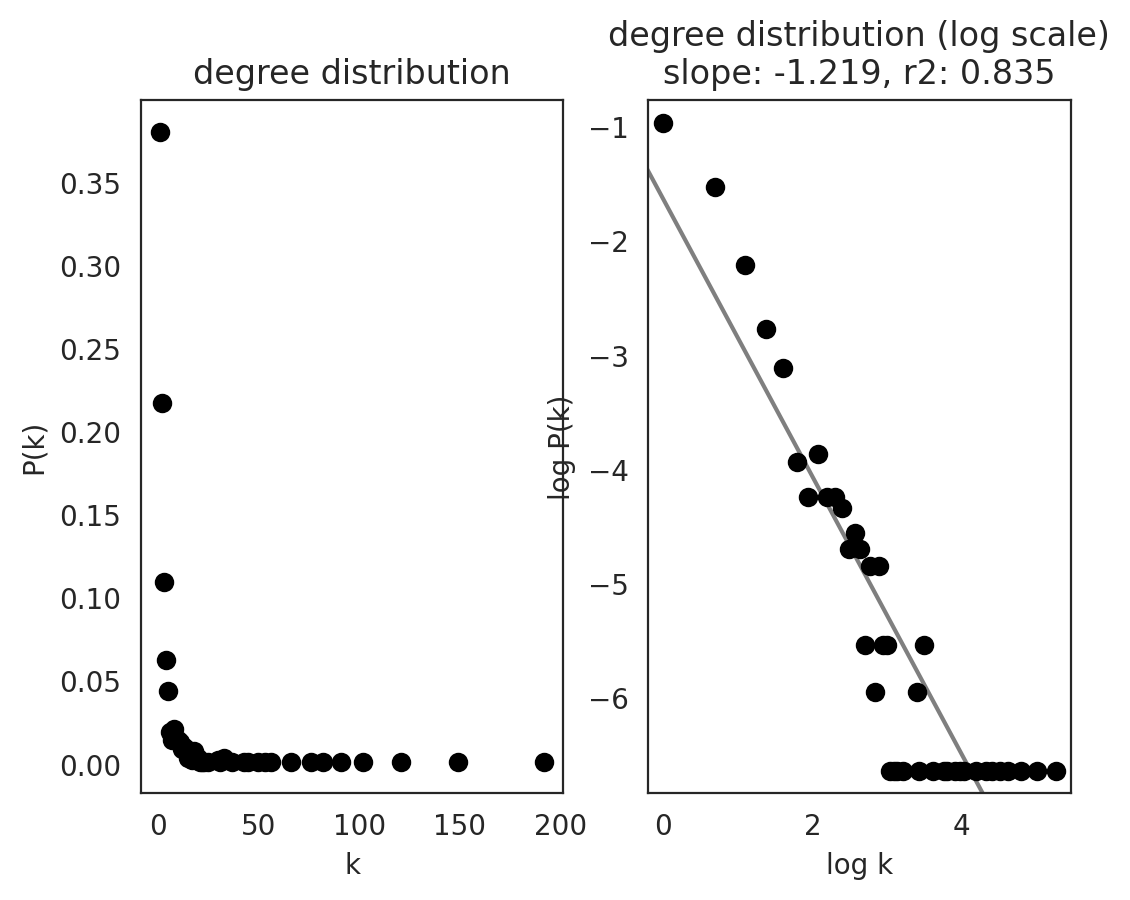

transient


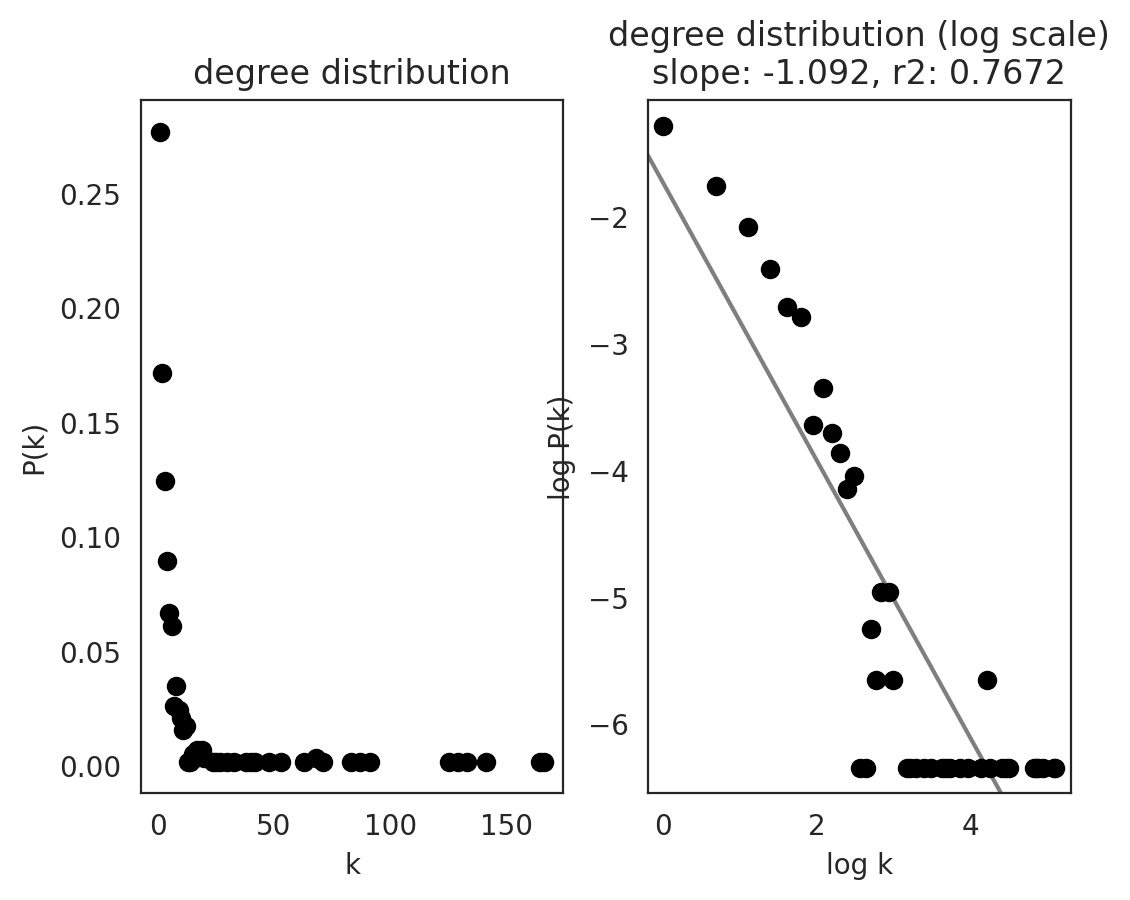

vRG


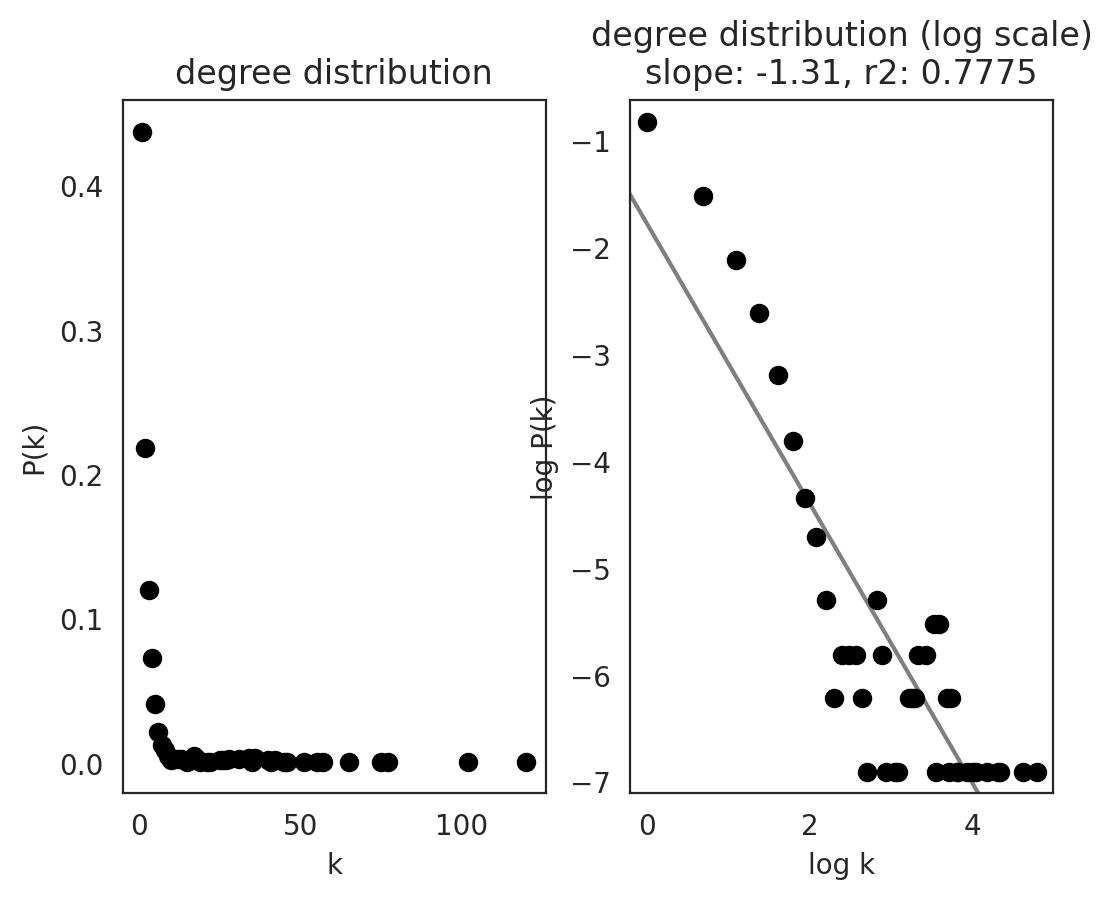

In [44]:
links_bayesian_ridge.plot_degree_distributions(plot_model=True)#save=f"{save_folder}/degree_distribution/",)

**Next, we calculate several network scores.**

In [45]:
# Calculate network scores.
links.get_network_score()

In [46]:
links.merged_score.head()

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
NEUROD2         155               0.277778         10              0.017921   
STMN2            30               0.053763         30              0.053763   
SOX2            199               0.356631          8              0.014337   
TUBB2B           27               0.048387         27              0.048387   
TFAP2C          157               0.281362          3              0.005376   

         degree_out  degree_centrality_out  betweenness_centrality  \
NEUROD2         145               0.259857                  3465.0   
STMN2             0               0.000000                     0.0   
SOX2            191               0.342294                  4710.0   
TUBB2B            0               0.000000                     0.0   
TFAP2C          154               0.275986                  2243.0   

         eigenvector_centrality cluster  
NEUROD2                0.744400     IPC  
STMN2                  0.531447     IPC  
SOX2                   1.000000     IPC  
TUBB2B                 0.470314     IPC  
TFAP2C                 0.977427     IPC

In [47]:
# Calculate network scores.
links_bayesian_ridge.get_network_score()

In [48]:
links_bayesian_ridge.merged_score.head()

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
EGR2          100               0.138504          0              0.000000   
ATRX            6               0.008310          6              0.008310   
FOS            95               0.131579          6              0.008310   
NNAT           22               0.030471         22              0.030471   
DDAH2           4               0.005540          4              0.005540   

       degree_out  degree_centrality_out  betweenness_centrality  \
EGR2          100               0.138504                     0.0   
ATRX            0               0.000000                     0.0   
FOS            89               0.123269                  1628.0   
NNAT            0               0.000000                     0.0   
DDAH2           0               0.000000                     0.0   

       eigenvector_centrality cluster  
EGR2                 0.652225     IPC  
ATRX                 0.262114     IPC  
FOS                  0.695157     IPC  
NNAT                 0.616224     IPC  
DDAH2                0.251903     IPC

In [49]:
# Save Links object.
links.to_hdf5(file_path="/home/jovyan/jm_jlab/data_indNeuro/1.GRN/pol19_baggingridge.links.celloracle.links")

In [50]:
# Save Links object.
links_bayesian_ridge.to_hdf5(file_path="/home/jovyan/jm_jlab/data_indNeuro/1.GRN/pol19_bayesianridge.links.celloracle.links")

## Network analysis

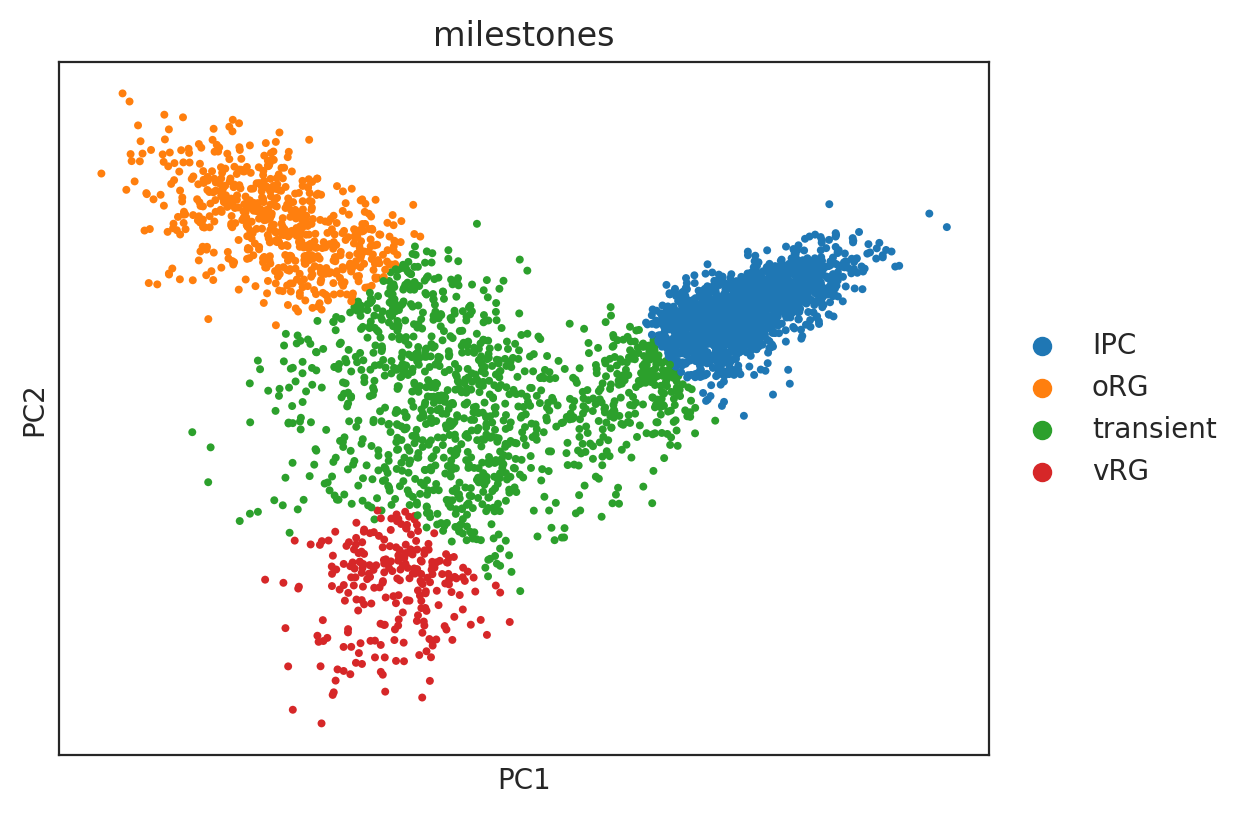

In [51]:
sc.pl.pca(adata, color='milestones')

IPC


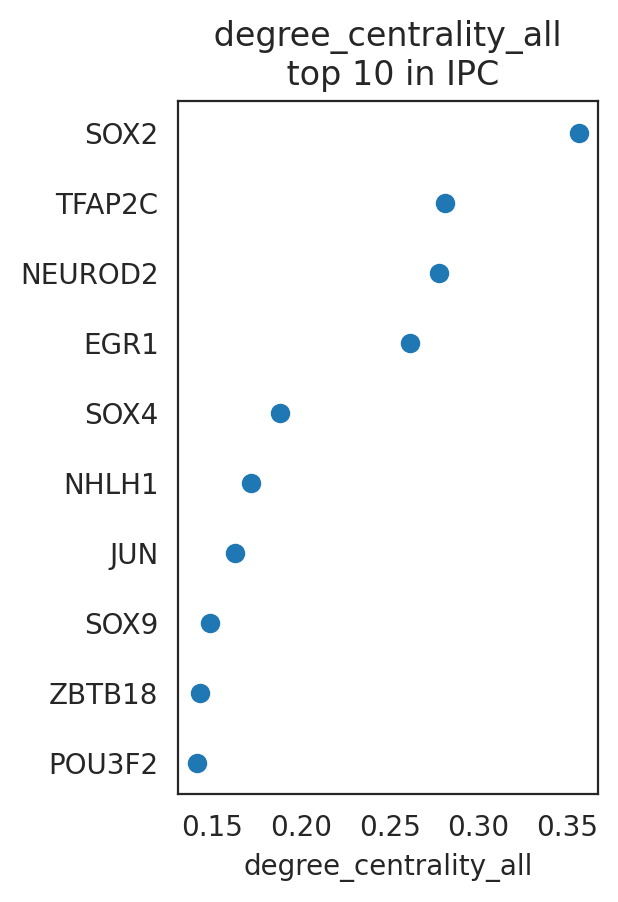

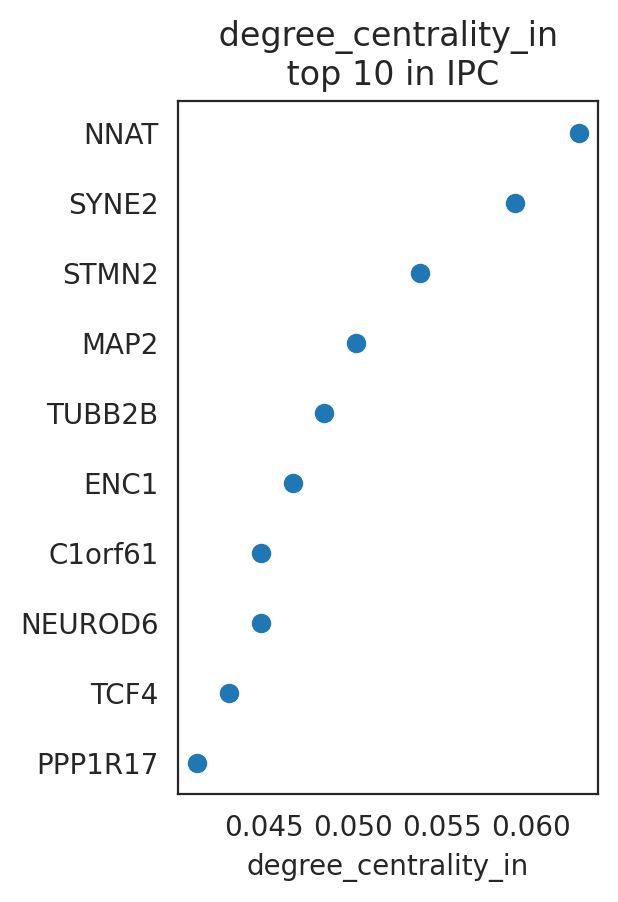

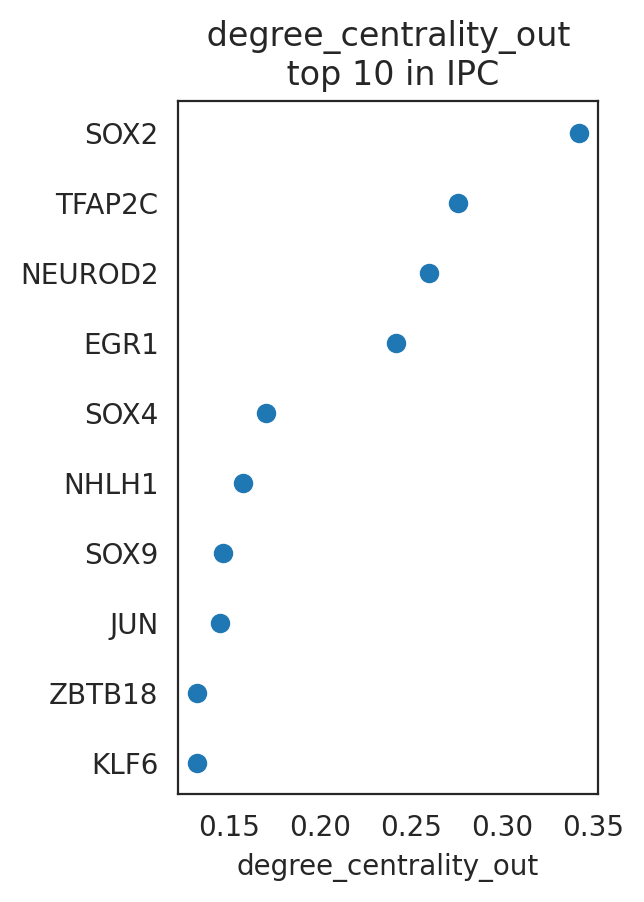

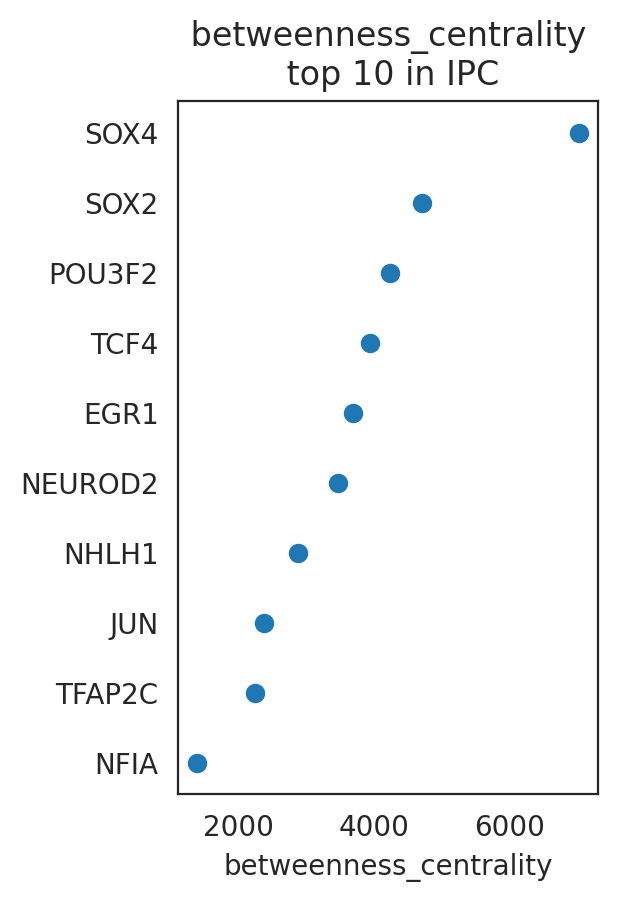

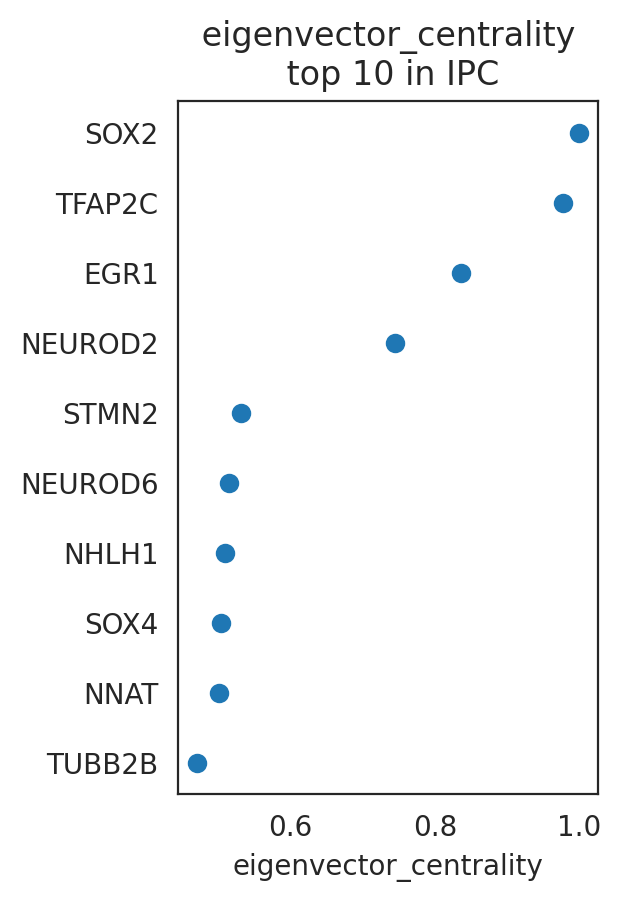

oRG


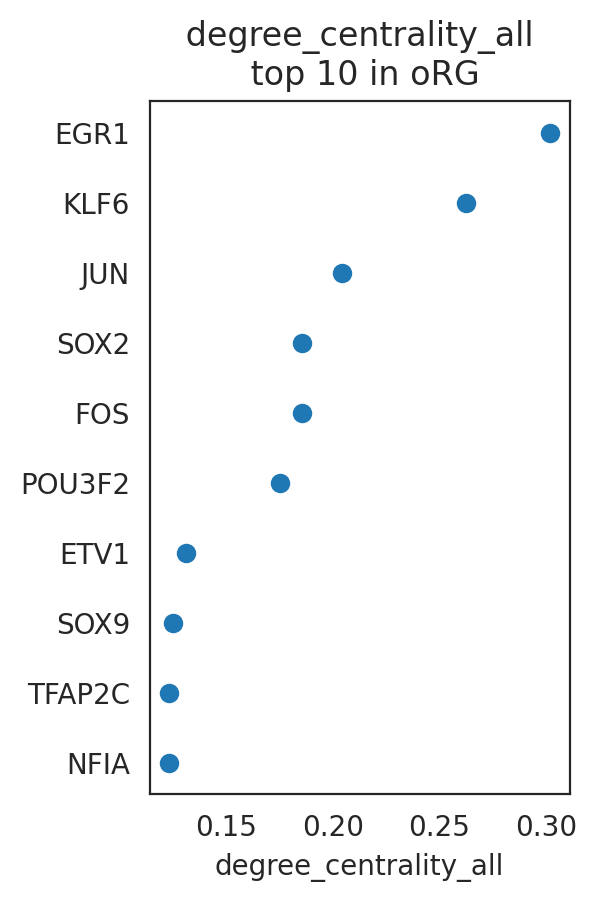

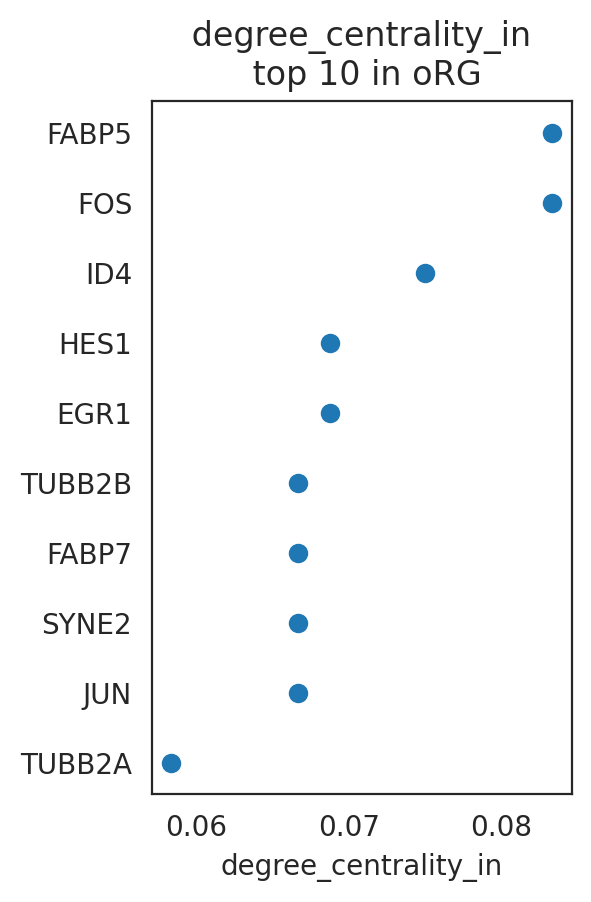

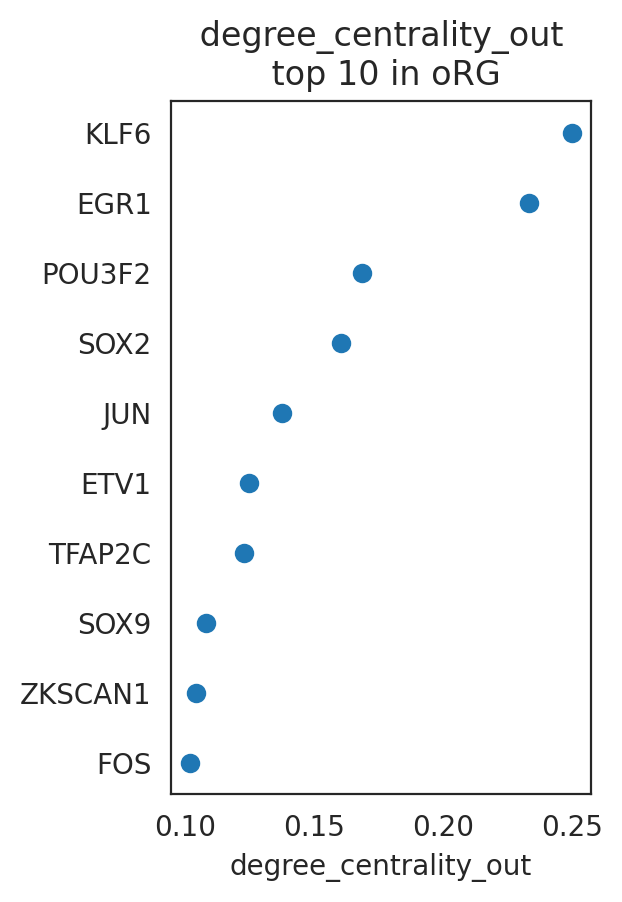

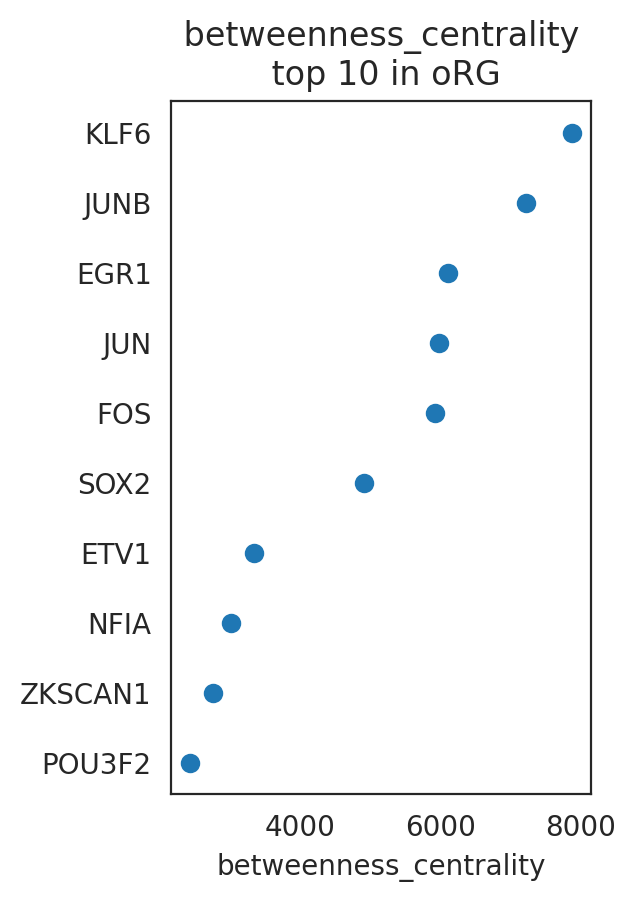

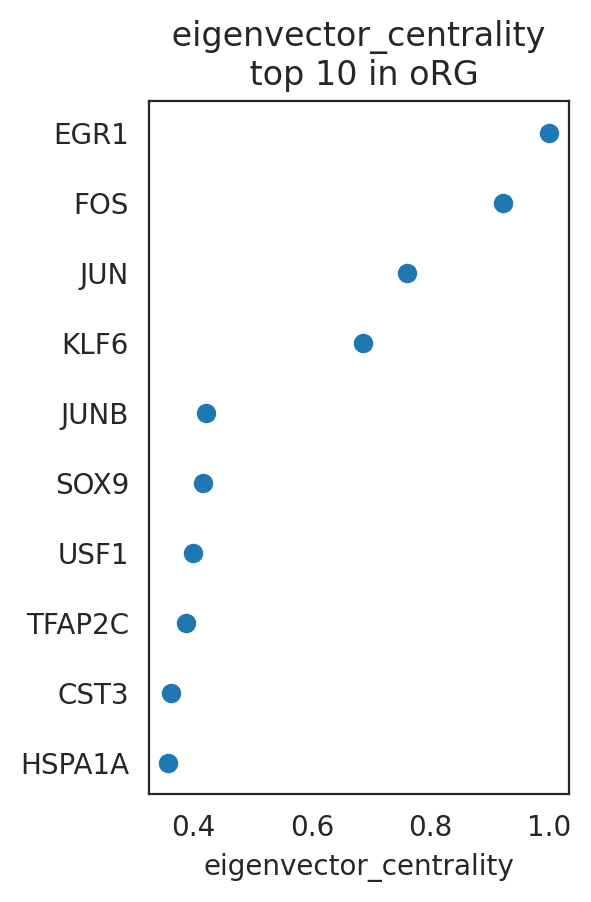

transient


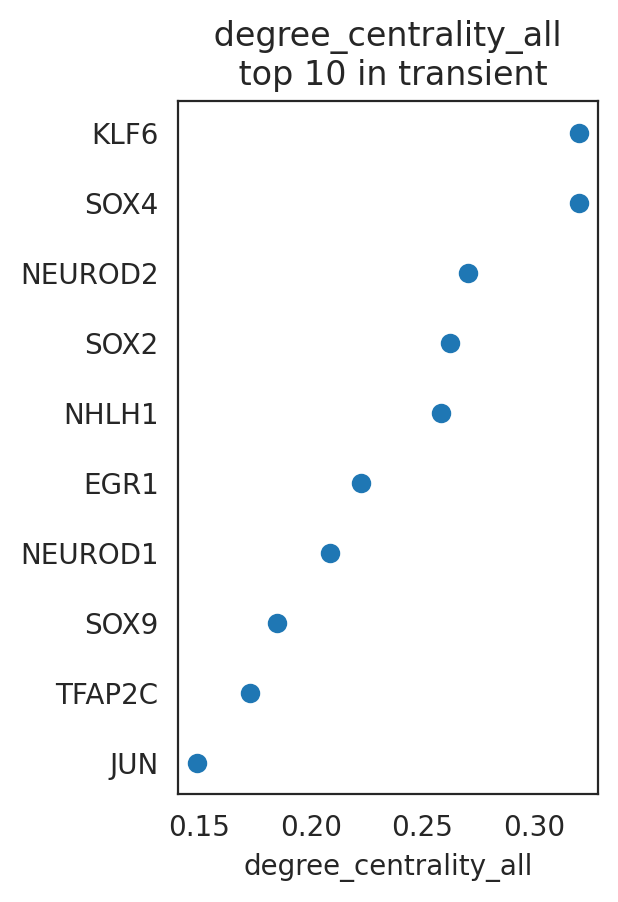

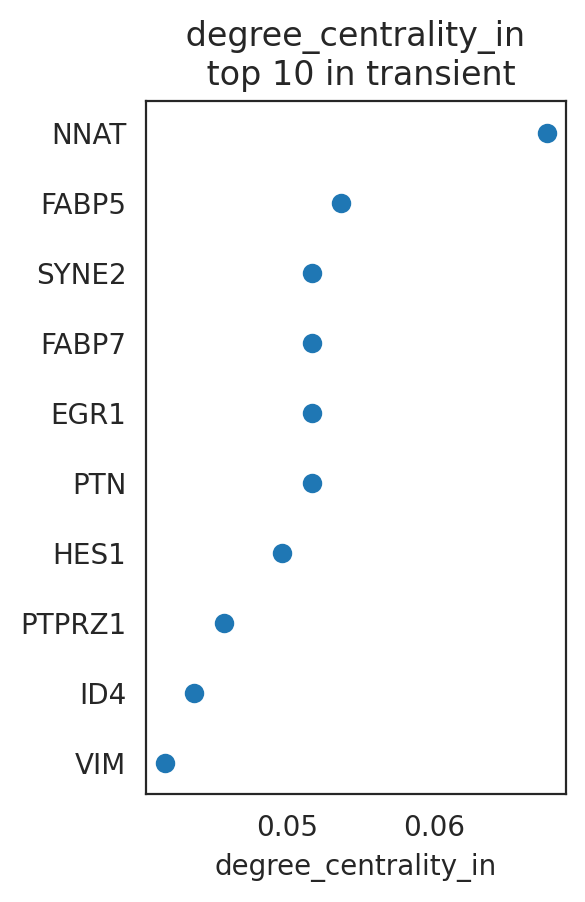

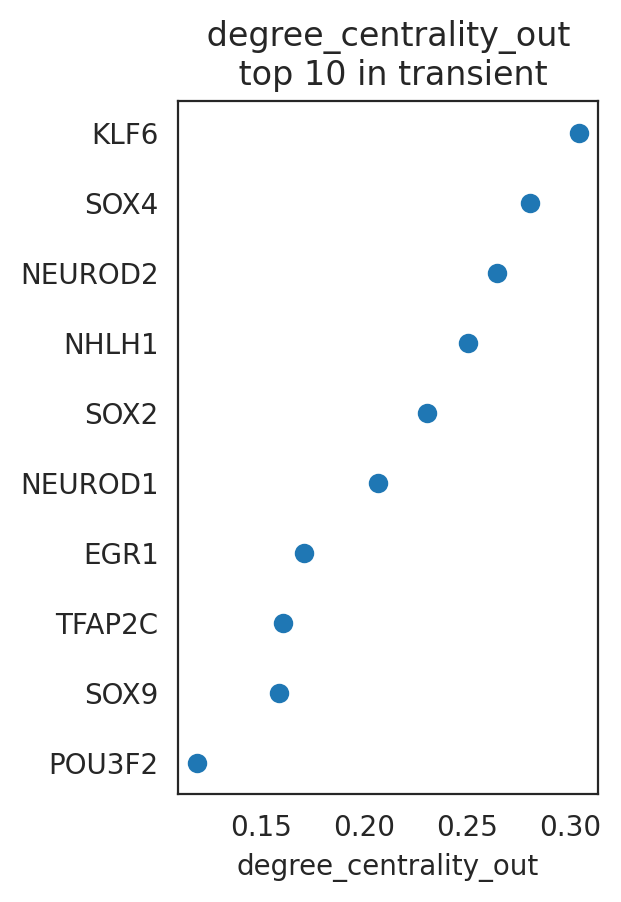

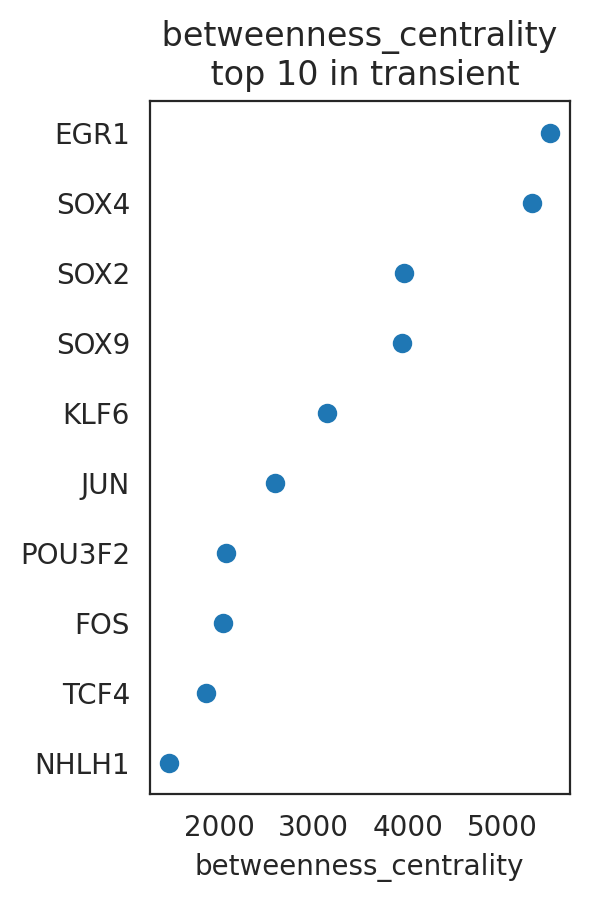

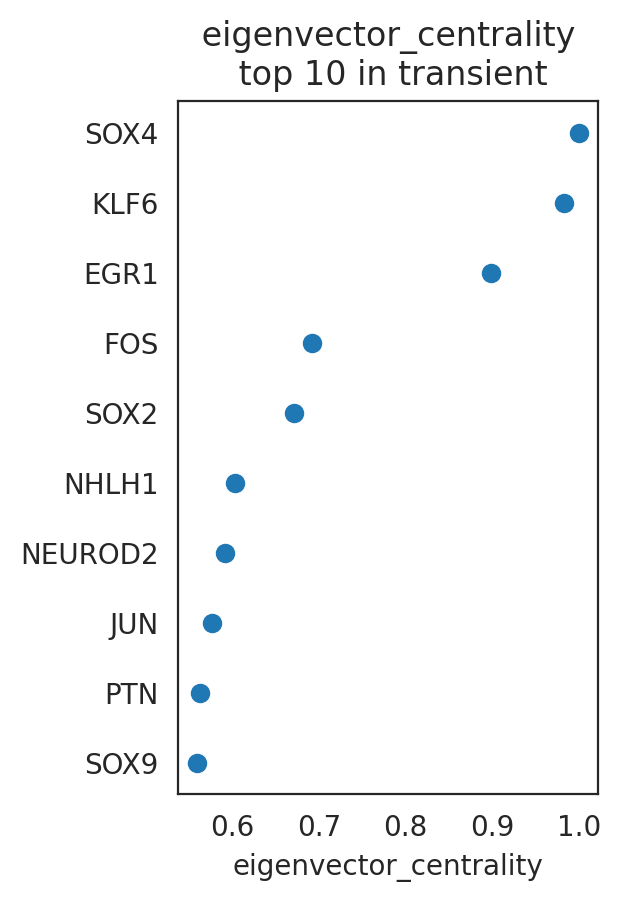

vRG


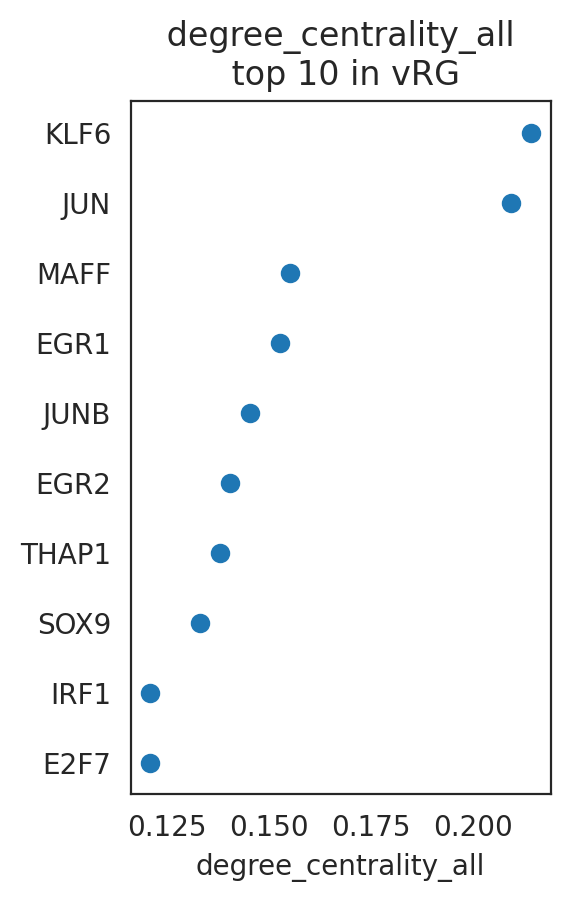

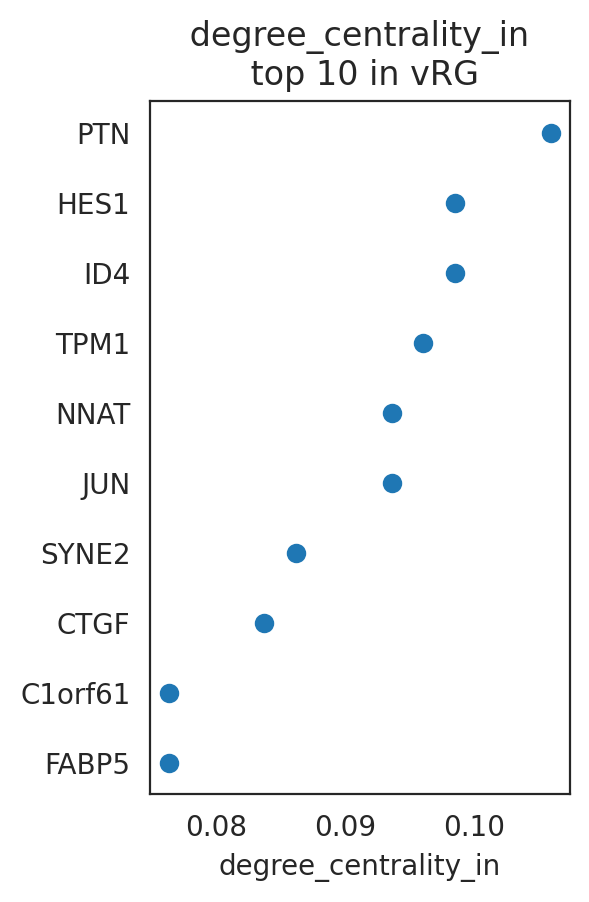

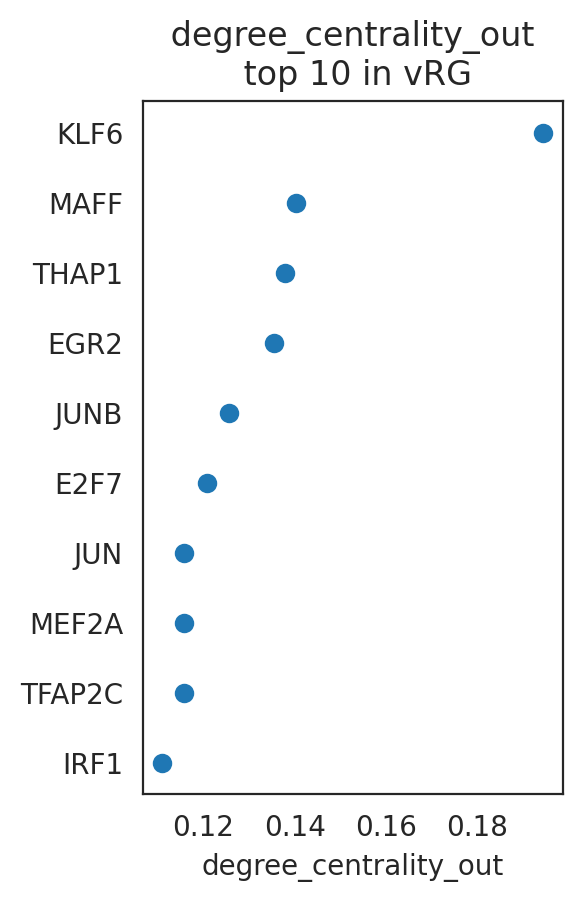

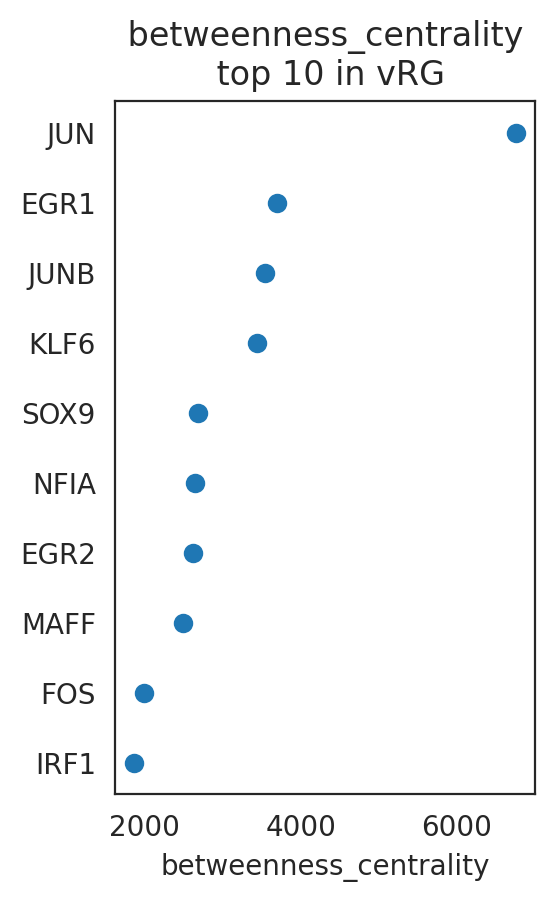

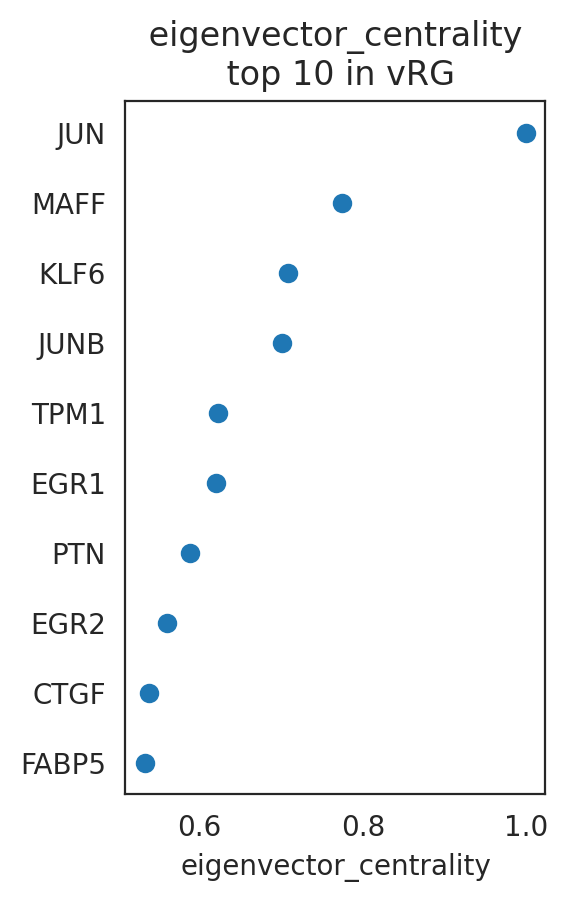

In [52]:
for i in links.filtered_links.keys():

    print(i)
    
    links.plot_scores_as_rank(cluster=i, n_gene=10)

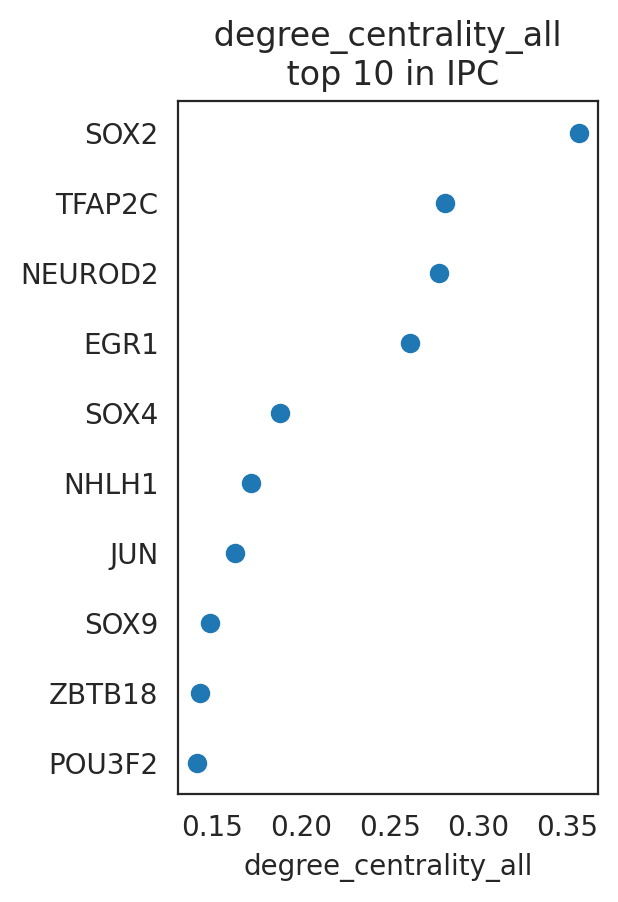

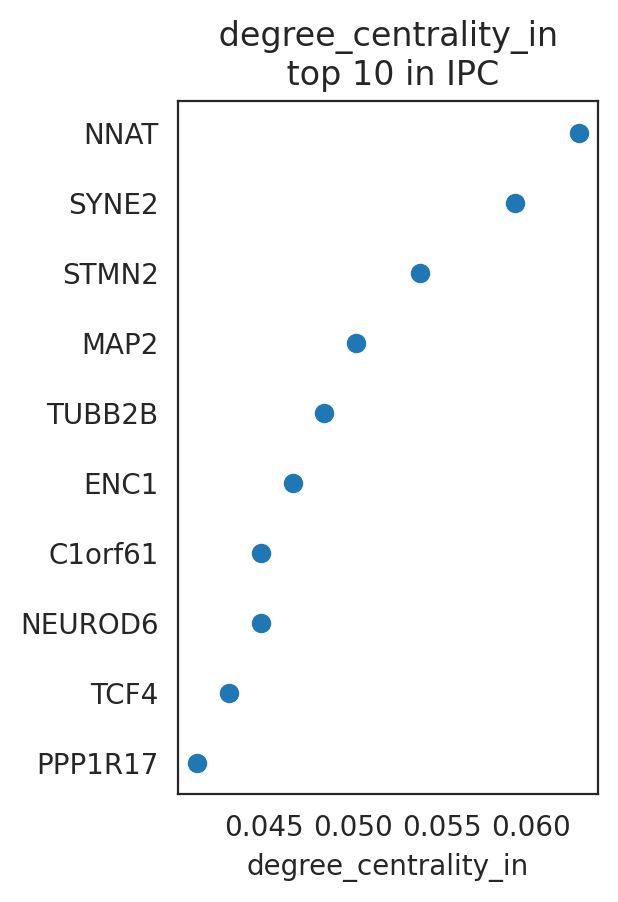

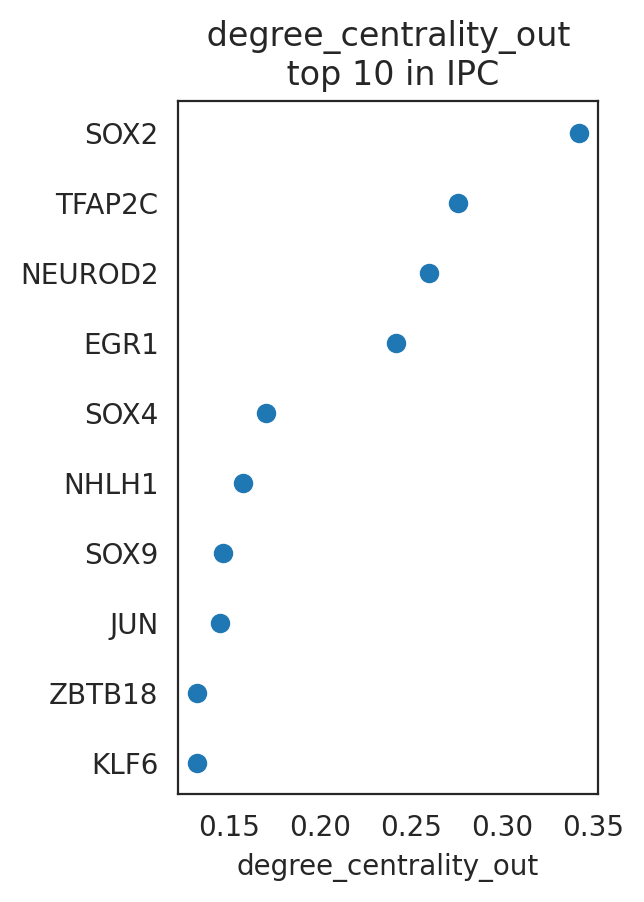

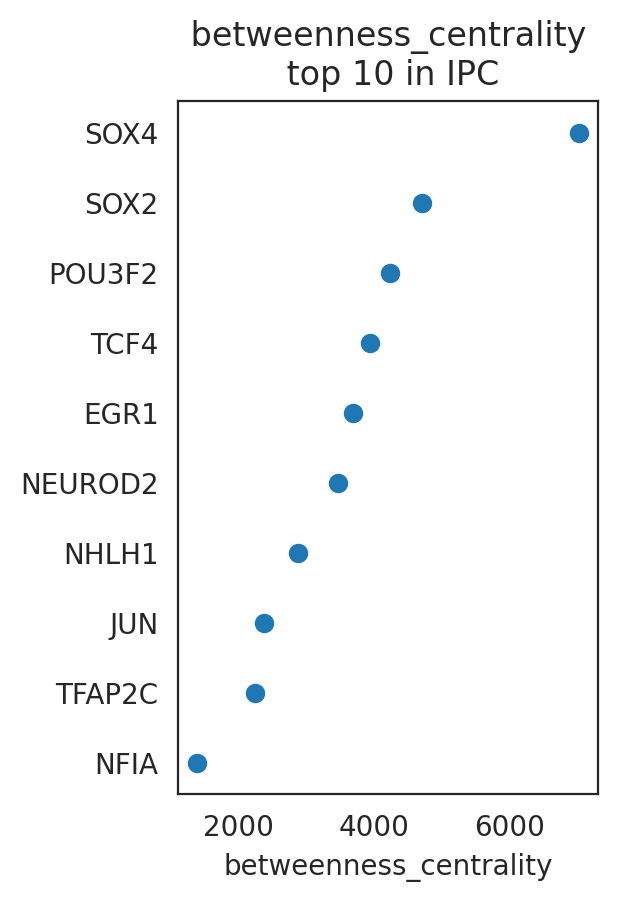

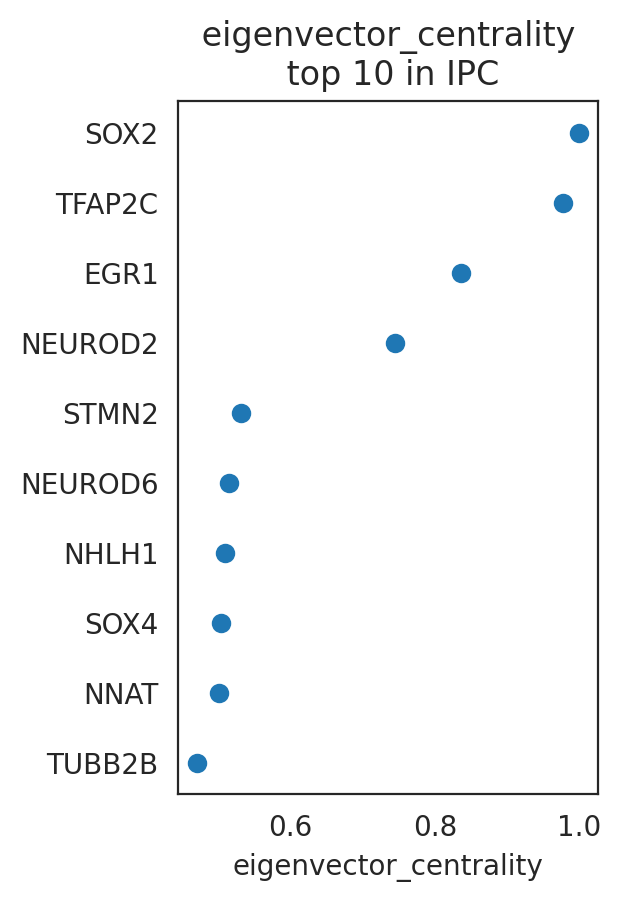

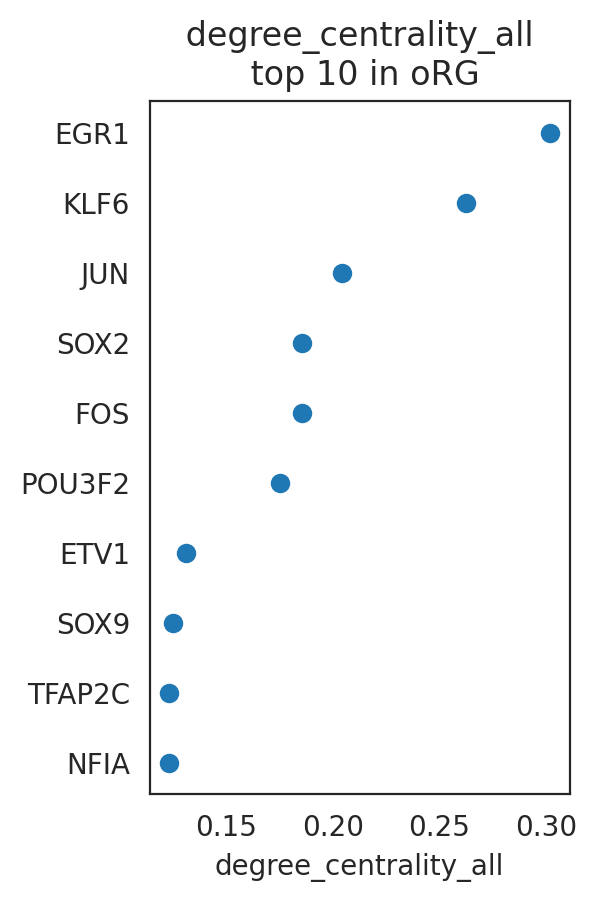

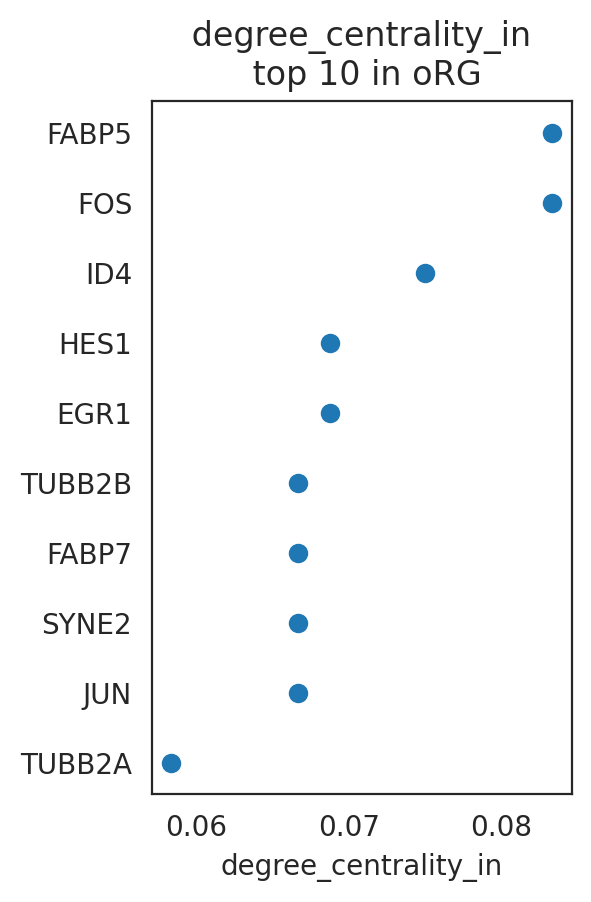

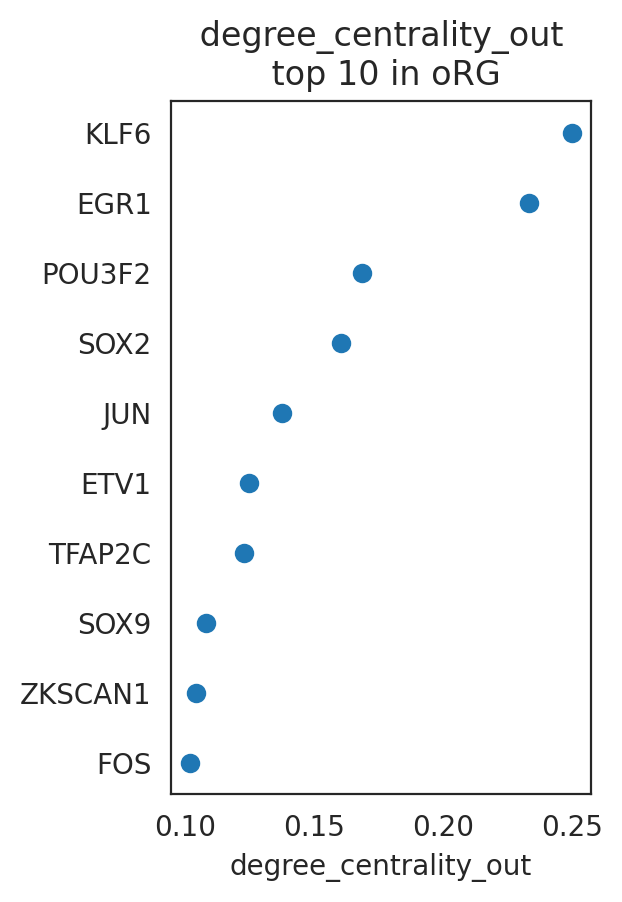

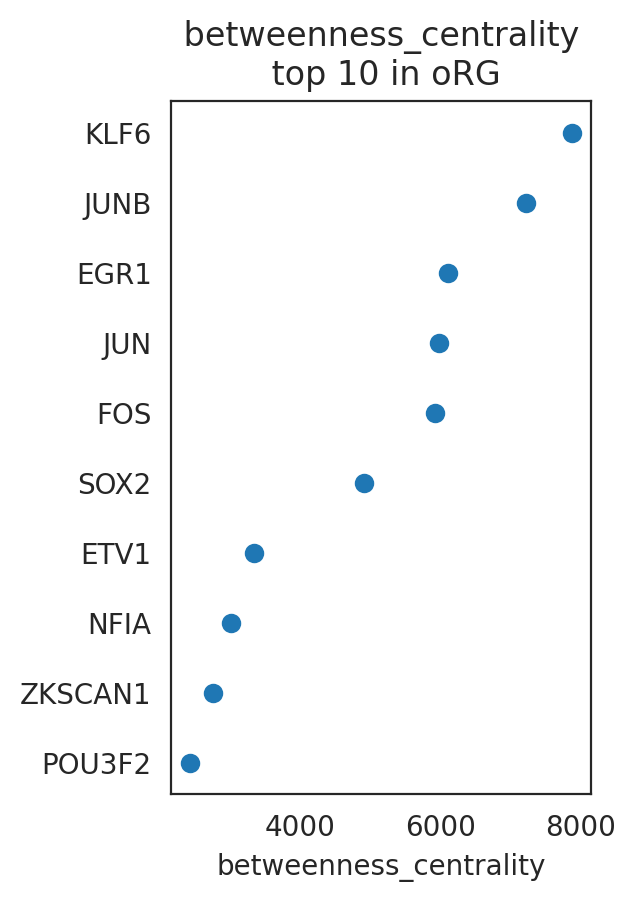

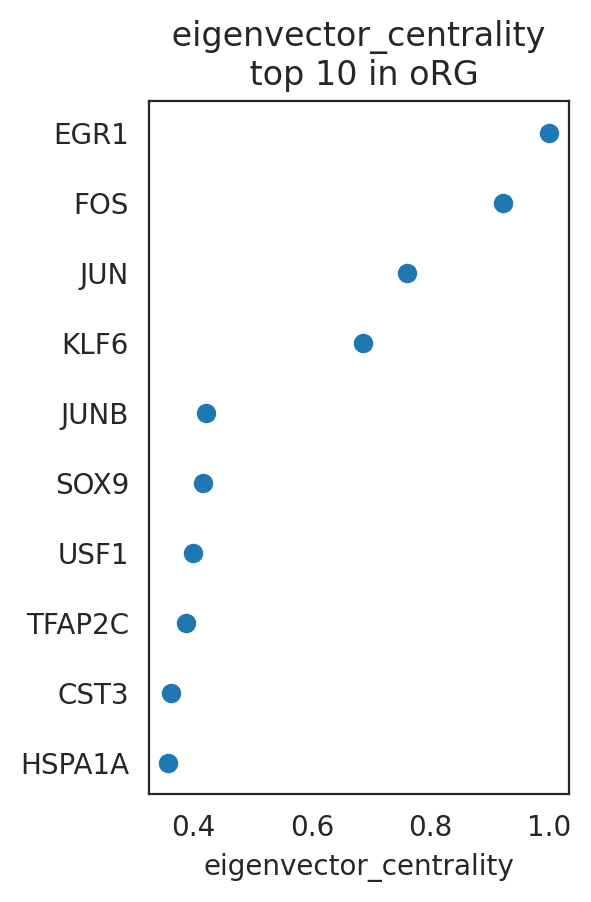

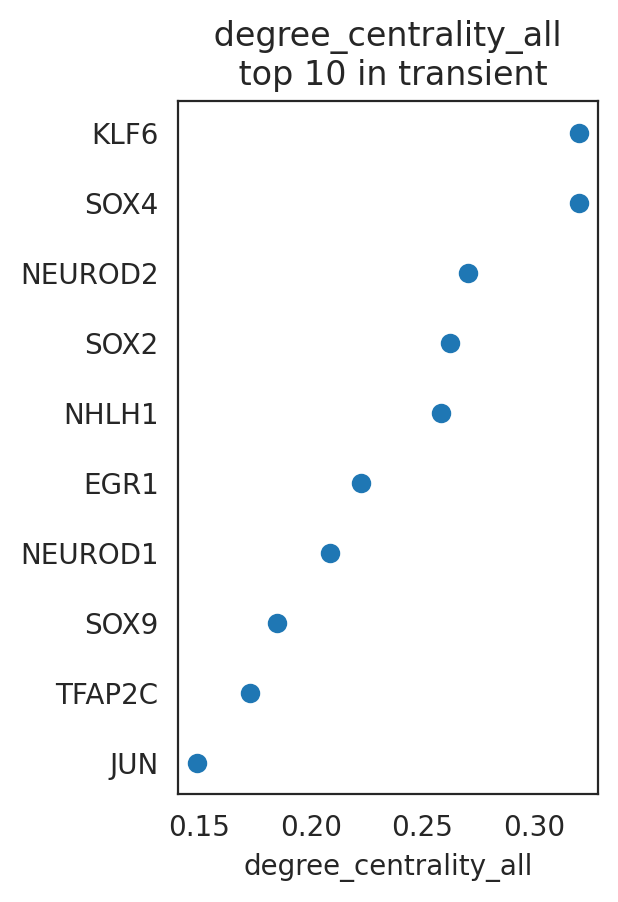

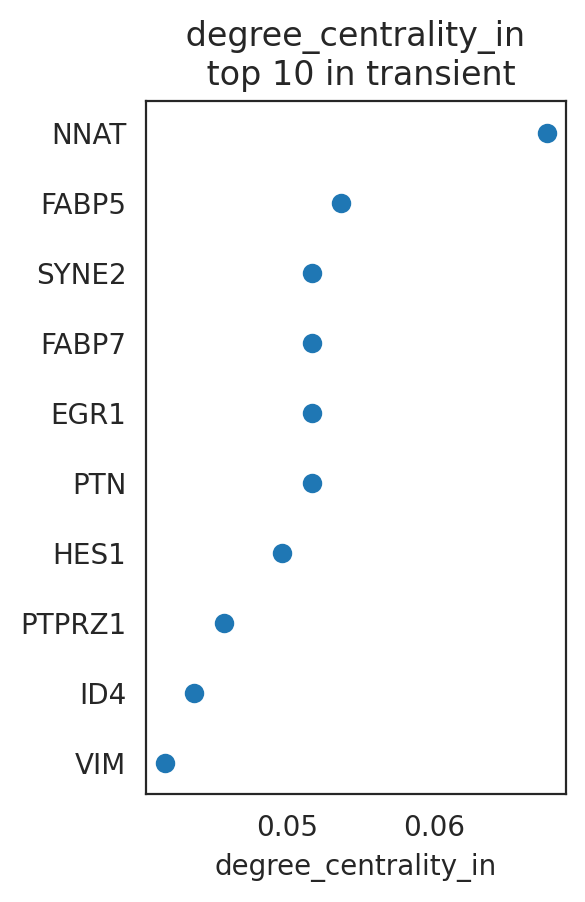

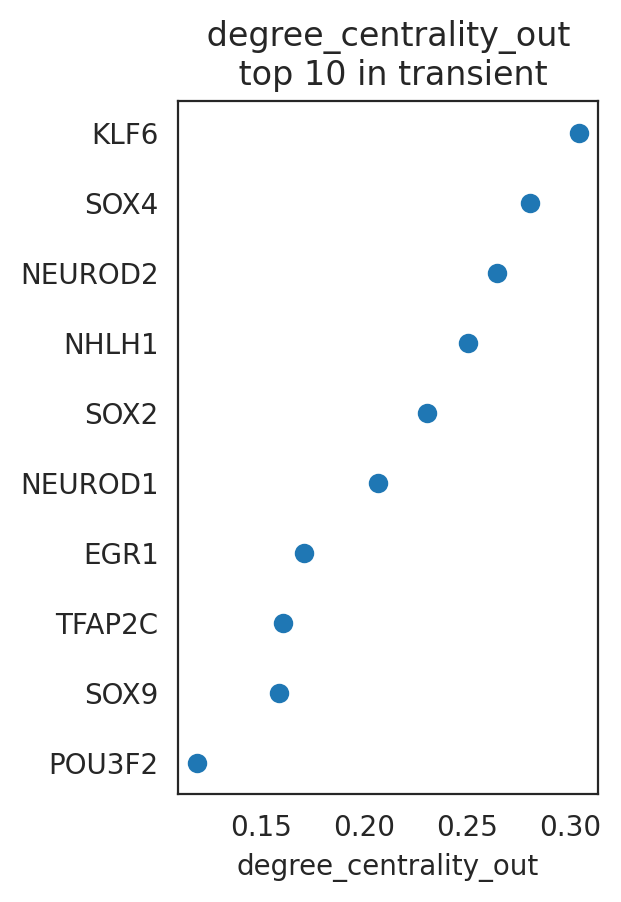

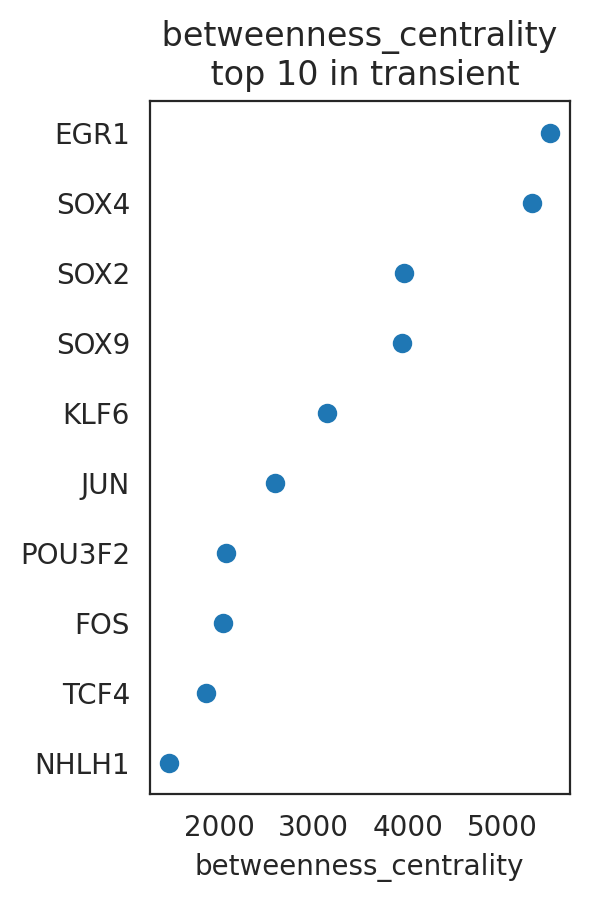

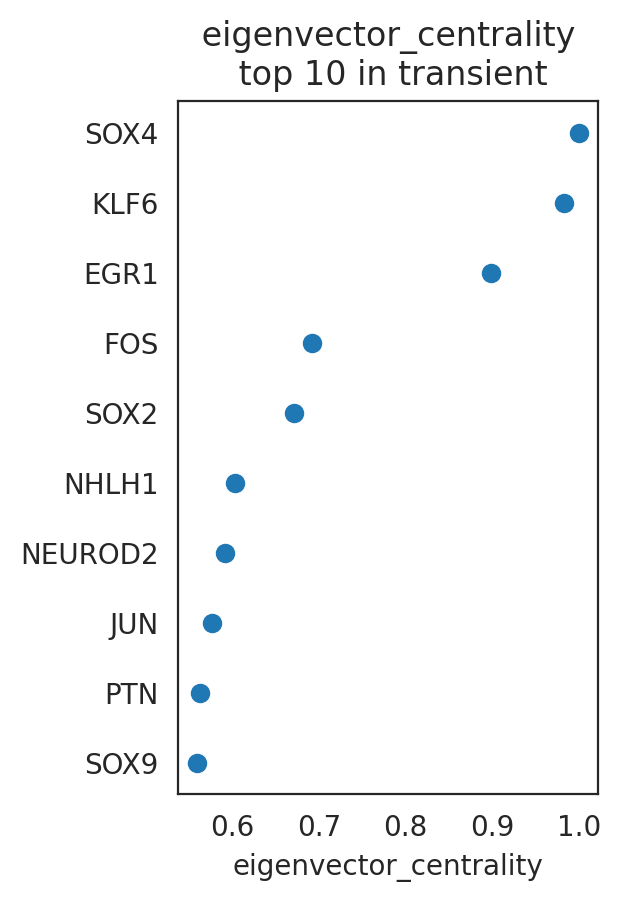

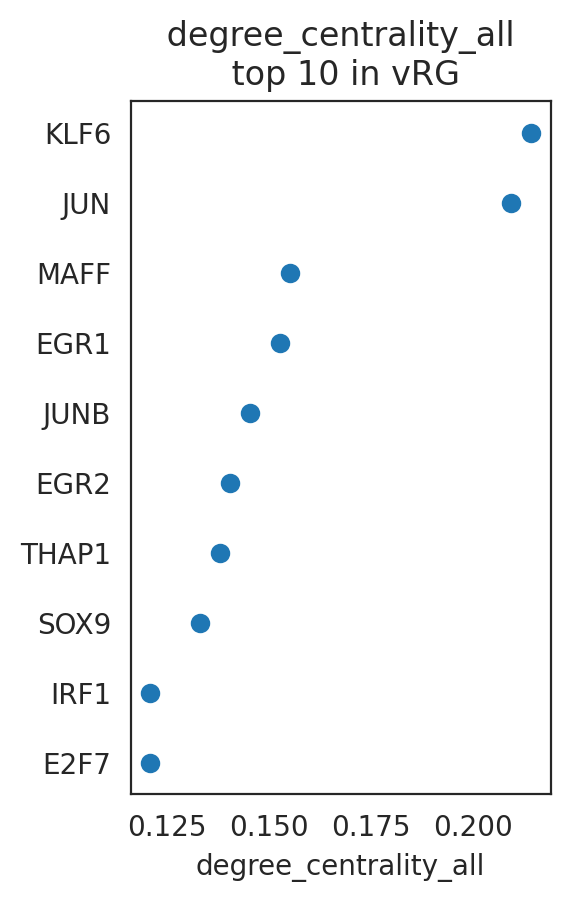

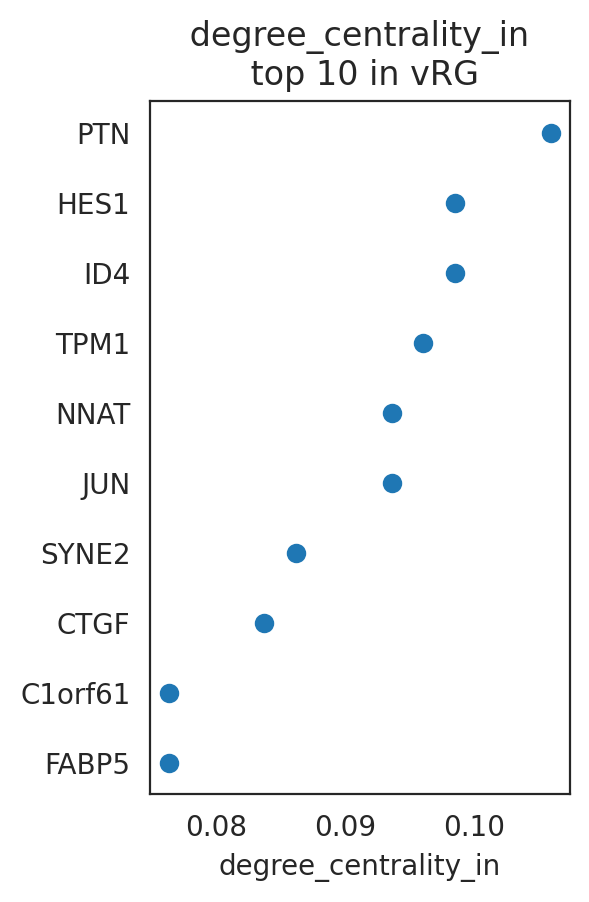

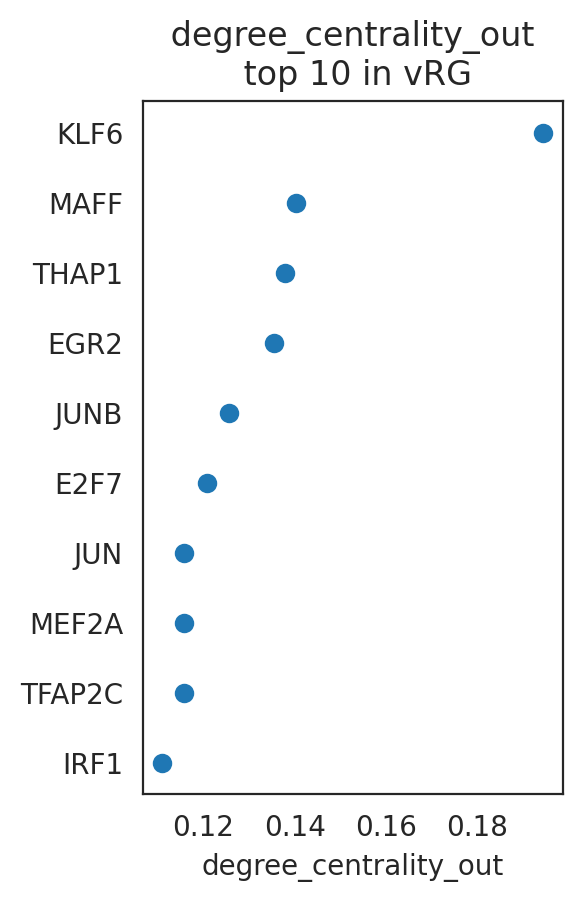

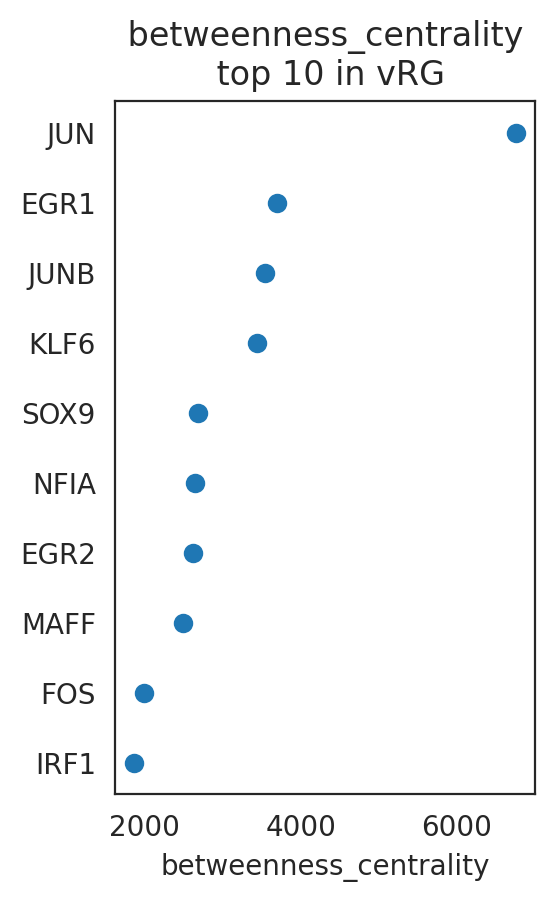

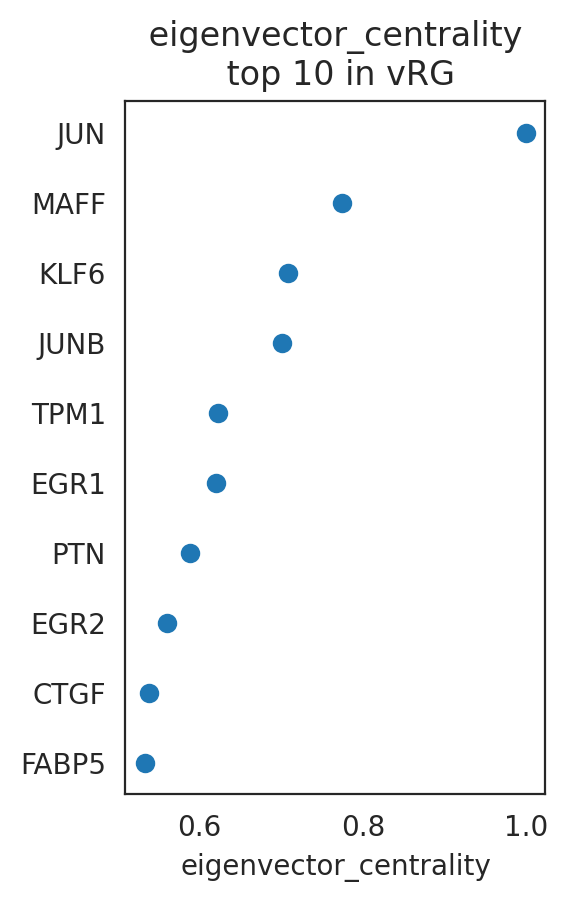

In [53]:
for i in links.filtered_links.keys():
    
    links.plot_scores_as_rank(cluster=i, n_gene=10, save=save_filtered_links+"GRN_for_"+i+"_pol19_milestones")

KLF6


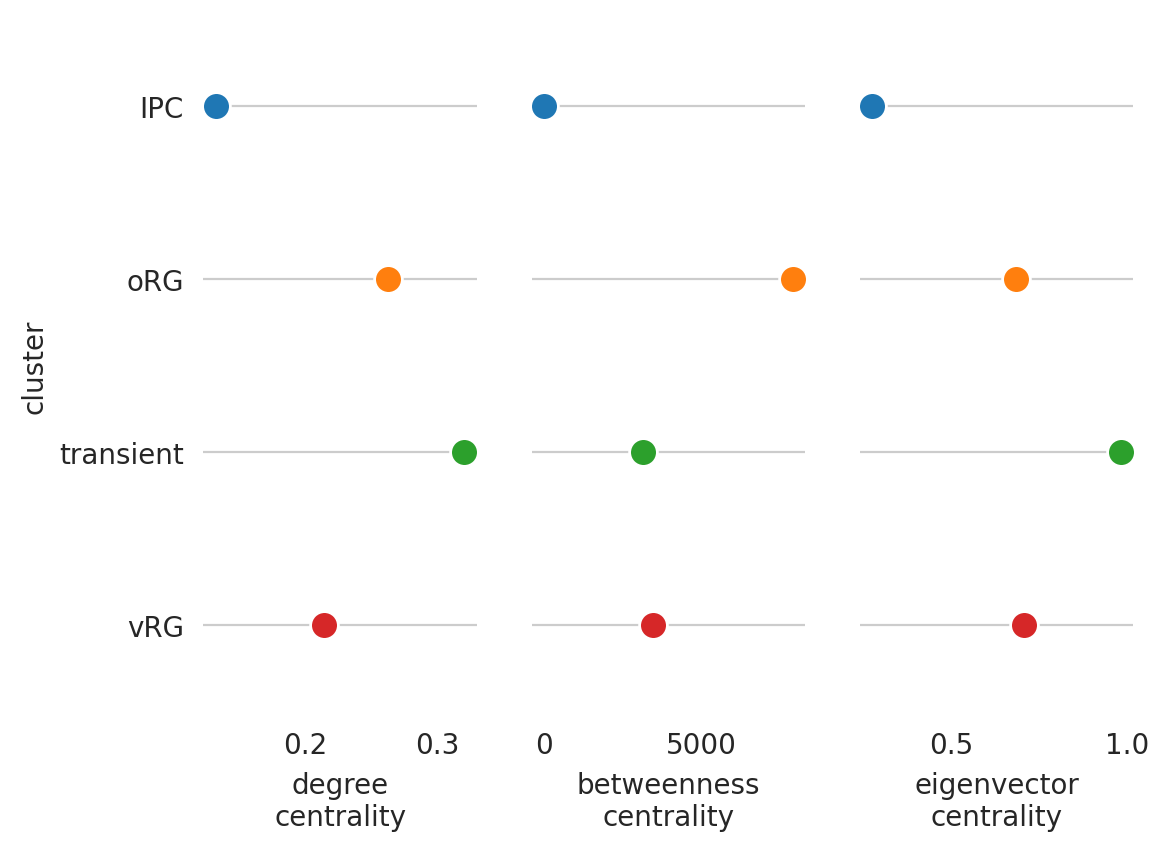

In [54]:
links.plot_score_per_cluster(goi="KLF6")

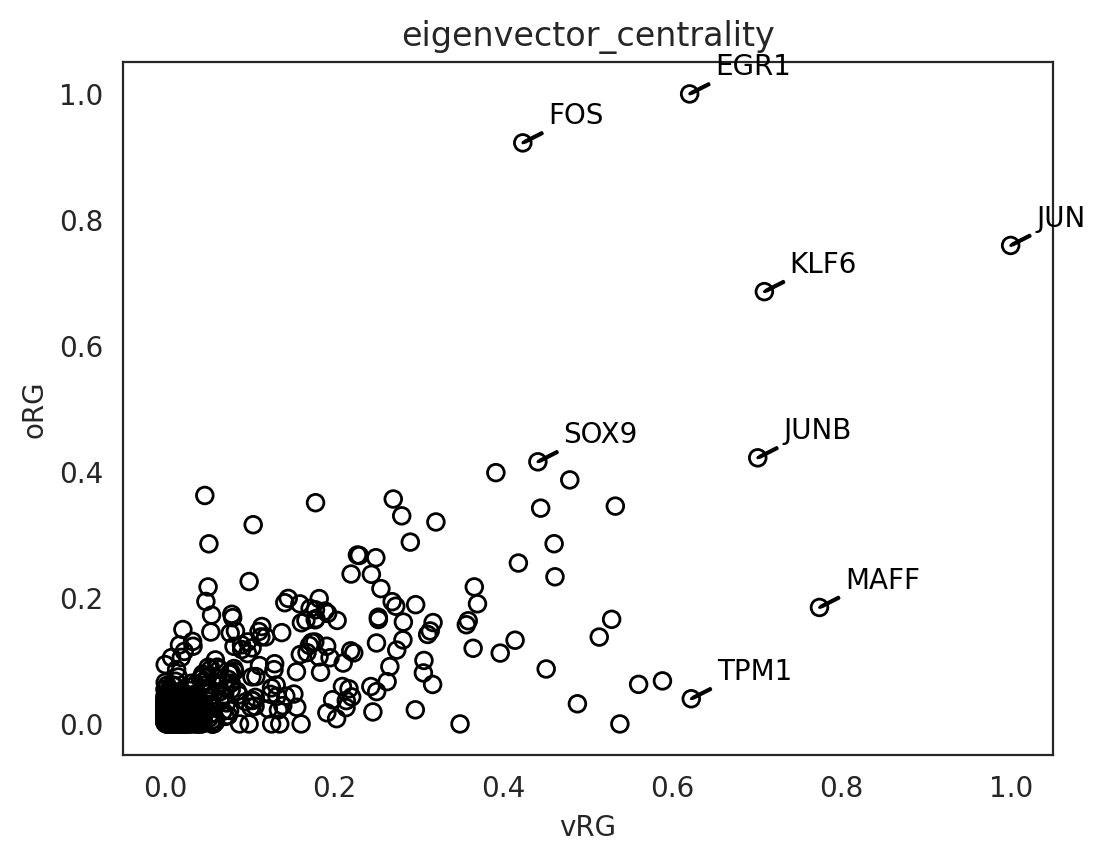

In [55]:
plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="vRG", cluster2="oRG",
                               percentile=99)#, save=f"{save_folder}/score_comparison")

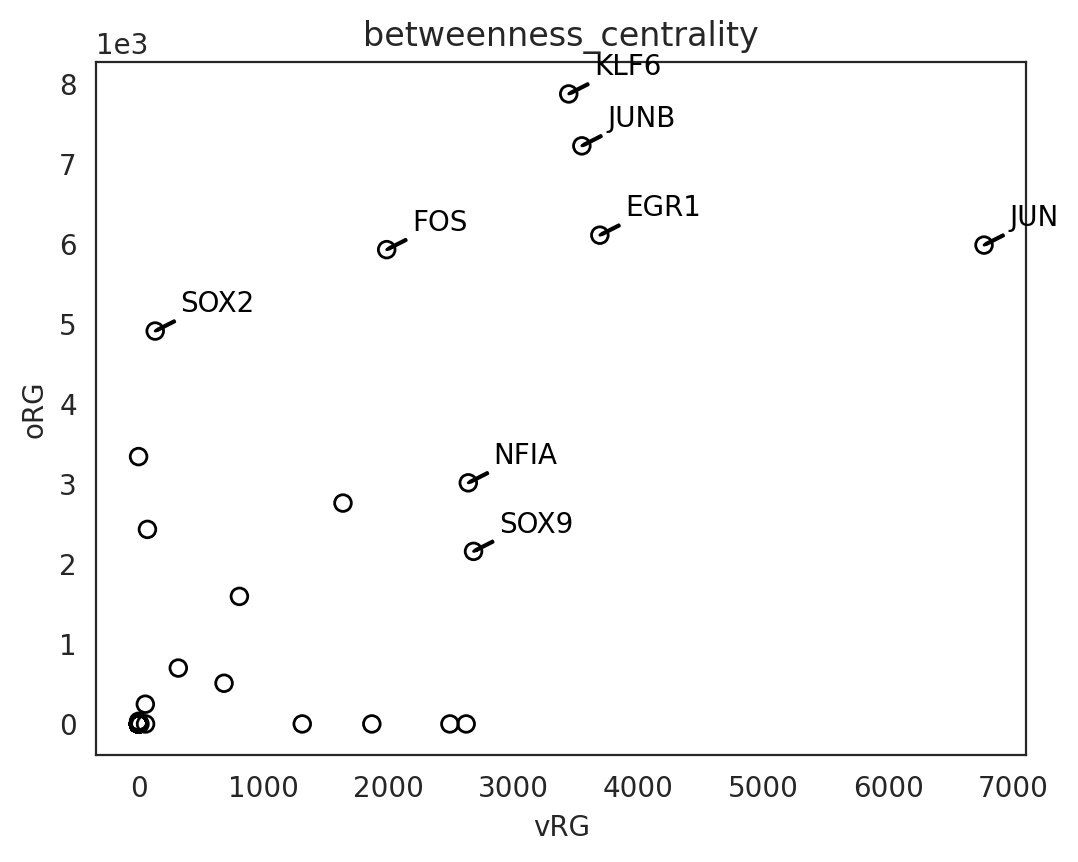

In [56]:
plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1="vRG", cluster2="oRG",
                               percentile=99)#, save=f"{save_folder}/score_comparison")

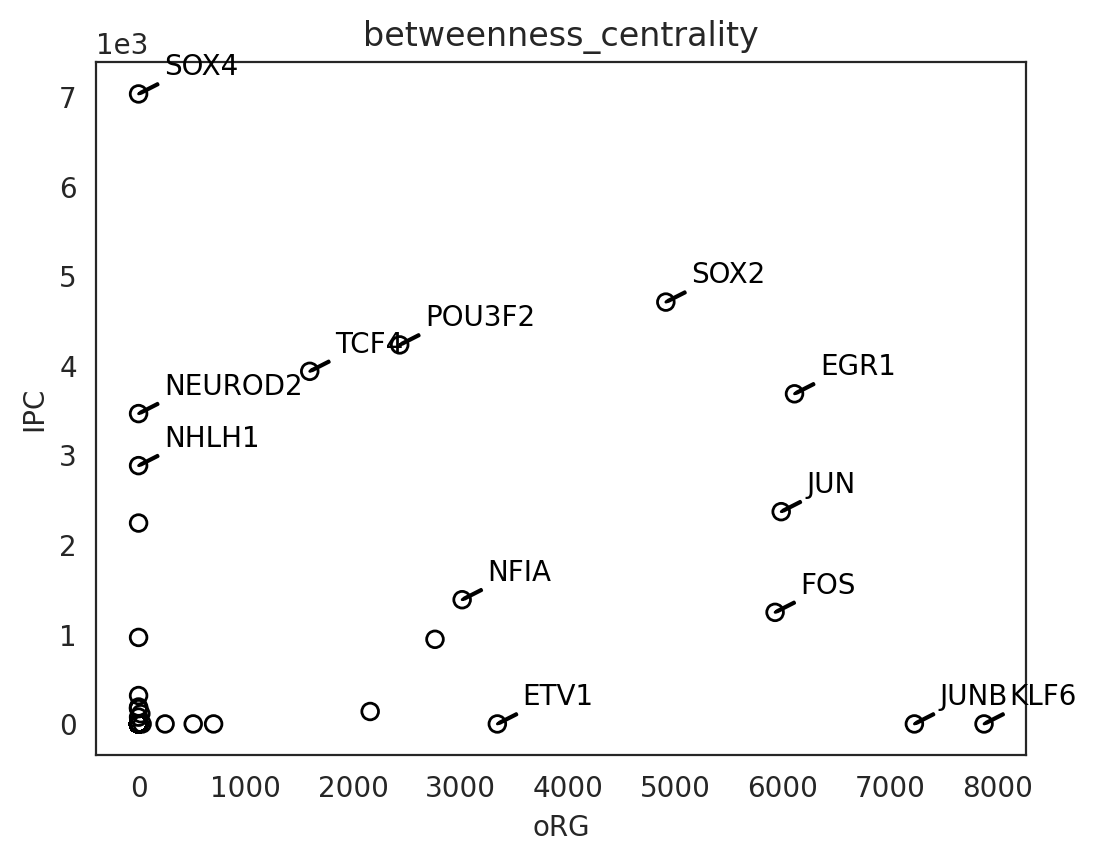

In [57]:
plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1="oRG", cluster2="IPC",
                               percentile=99)#, save=f"{save_folder}/score_comparison")

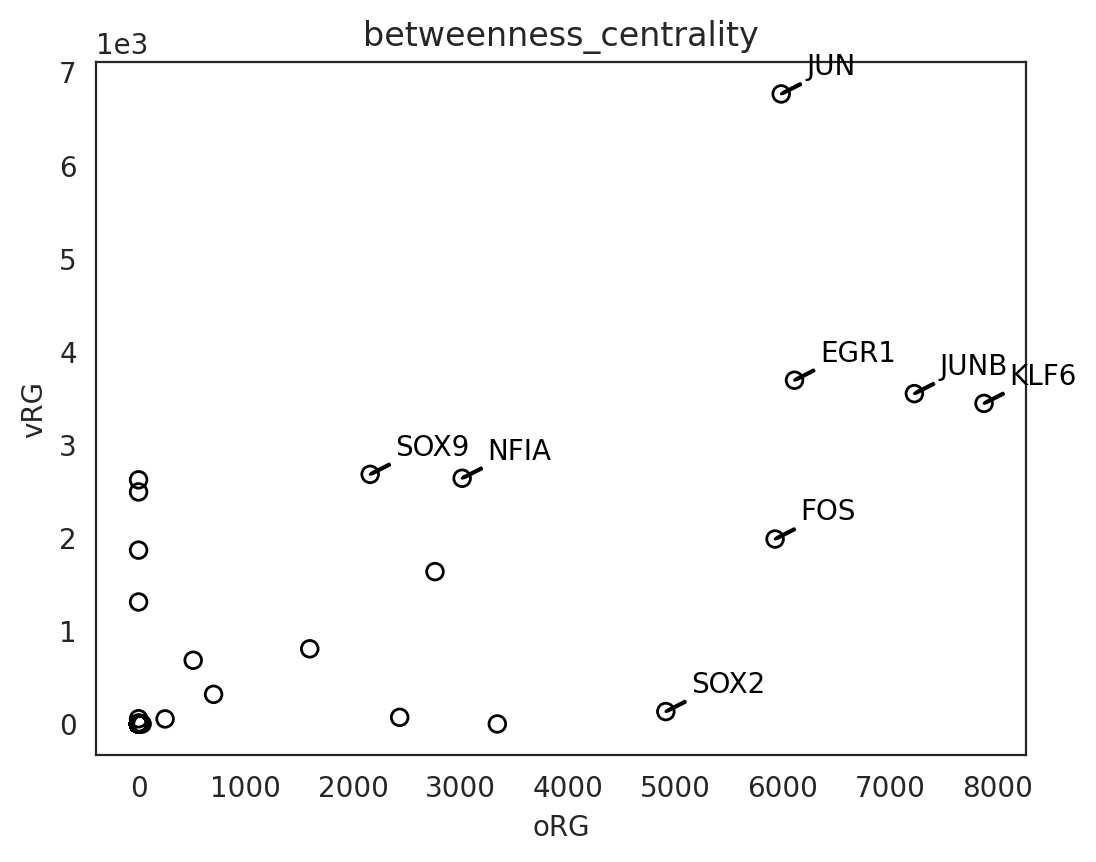

In [58]:
plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1="oRG", cluster2="vRG",
                               percentile=99)#, save=f"{save_folder}/score_comparison")

# Save object

In [59]:
oracle.to_hdf5("/home/jovyan/jm_jlab/data_indNeuro/1.GRN/pol19.celloracle.oracle")